# Climate scenario data

In this notebook we will...
1. ... aggregate and download climate scenario data from the Coupled Model Intercomparison Project Phase 6 ([CMIP6](https://wcrp-cmip.org/cmip-phase-6-cmip6/)) for our catchment,
2. ... preprocess the data,
3. ... compare the CMIP6 models with our reanalysis data and adjust them for bias,
4. ... and visualize the data before and after bias adjustment.

The [NEX-GDDP-CMIP6 dataset](https://www.nature.com/articles/s41597-022-01393-4) we are going to use has been downscaled to 27830 m resolution by the [NASA Climate Analytics Group](https://www.nature.com/articles/s41597-022-01393-4) and is available in two [Shared Socio-Economic Pathways](https://unfccc.int/sites/default/files/part1_iiasa_rogelj_ssp_poster.pdf) (SSP2 and SSP5). It is available via [Google Earth Engine](https://developers.google.com/earth-engine/datasets/catalog/NASA_GDDP-CMIP6#bands) which makes it subsettable on the server side and the download relatively light-weight.

We start by importing and initializing the Google Earth Engine packages again.

In [33]:
import ee
import geemap
import numpy as np

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='matilda-edu')

The next cell reads the output directory location and the catchment outline as target polygon.

In [34]:
import configparser
import ast
import geopandas as gpd

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get paths from config.ini
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']
dir_figures = config['FILE_SETTINGS']['DIR_FIGURES']
output_gpkg = dir_output + config['FILE_SETTINGS']['GPKG_NAME']

# get style for matplotlib plots
# plt_style = ast.literal_eval(config['CONFIG']['PLOT_STYLE'])

# set the file format for storage
compact_files = config.getboolean('CONFIG','COMPACT_FILES')

# load catchment outline as target polygon
catchment_new = gpd.read_file(output_gpkg, layer='catchment_new')
catchment = geemap.geopandas_to_ee(catchment_new)

# name target subdirectory to be created
cmip_dir = dir_output + 'cmip6/'

## Select, aggregate, and download downscaled CMIP6 data

We are going to create a class that does it all in one go. The `buildFeauture()` function requests daily catchment-wide averages of all available CMIP6 models for individual years. All years requested are stored in an `ee.ImageCollection` by `getResult()`. To provide the best basis for bias adjustment a large overlap of reanalysis and scenario data is recommended. By default, the `CMIPDownloader` class requests everything between the earliest available date from ERA5-Land (1979) and the latest available date from CMIP6 (2100). The `download()` function then starts a given number of parallel requests, each downloading a single year and storing them in CSV files.


In [3]:
import concurrent.futures
import os
import requests
from retry import retry
from tqdm import tqdm


class CMIPDownloader:
    """Class to download spatially averaged CMIP6 data for a given period, variable, and spatial subset."""

    def __init__(self, var, starty, endy, shape, processes=10, dir='./'):
        self.var = var
        self.starty = starty
        self.endy = endy
        self.shape = shape
        self.processes = processes
        self.directory = dir

        # create the download directory if it doesn't exist
        if not os.path.exists(self.directory):
            os.makedirs(self.directory)

    def download(self):
        """Runs a subset routine for CMIP6 data on GEE servers to create ee.FeatureCollections for all years in
        the requested period. Downloads individual years in parallel processes to increase the download time."""
        
        print('Initiating download request for NEX-GDDP-CMIP6 data from ' +
              str(self.starty) + ' to ' + str(self.endy) + '.')

        def getRequests(starty, endy):
            """Generates a list of years to be downloaded. [Client side]"""

            return [i for i in range(starty, endy+1)]

        @retry(tries=10, delay=1, backoff=2)
        def getResult(index, year):
            """Handle the HTTP requests to download one year of CMIP6 data. [Server side]"""

            start = str(year) + '-01-01'
            end = str(year + 1) + '-01-01'
            startDate = ee.Date(start)
            endDate = ee.Date(end)
            n = endDate.difference(startDate, 'day').subtract(1)

            def getImageCollection(var):
                """Create and image collection of CMIP6 data for the requested variable, period, and region.
                [Server side]"""

                collection = ee.ImageCollection('NASA/GDDP-CMIP6') \
                    .select(var) \
                    .filterDate(startDate, endDate) \
                    .filterBounds(self.shape)
                return collection

            def renameBandName(b):
                """Edit variable names for better readability. [Server side]"""

                split = ee.String(b).split('_')
                return ee.String(split.splice(split.length().subtract(2), 1).join("_"))

            def buildFeature(i):
                """Create an area weighted average of the defined region for every day in the given year.
                [Server side]"""

                t1 = startDate.advance(i, 'day')
                t2 = t1.advance(1, 'day')
                # feature = ee.Feature(point)
                dailyColl = collection.filterDate(t1, t2)
                dailyImg = dailyColl.toBands()
                # renaming and handling names
                bands = dailyImg.bandNames()
                renamed = bands.map(renameBandName)
                # Daily extraction and adding time information
                dict = dailyImg.rename(renamed).reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=self.shape,
                ).combine(
                    ee.Dictionary({'system:time_start': t1.millis(), 'isodate': t1.format('YYYY-MM-dd')})
                )
                return ee.Feature(None, dict)

            # Create features for all days in the respective year. [Server side]
            collection = getImageCollection(self.var)
            year_feature = ee.FeatureCollection(ee.List.sequence(0, n).map(buildFeature))

            # Create a download URL for a CSV containing the feature collection. [Server side]
            url = year_feature.getDownloadURL()

            # Handle downloading the actual csv for one year. [Client side]
            r = requests.get(url, stream=True)
            if r.status_code != 200:
                r.raise_for_status()
            filename = os.path.join(self.directory, 'cmip6_' + self.var + '_' + str(year) + '.csv')
            with open(filename, 'w') as f:
                f.write(r.text)

            return index

        # Create a list of years to be downloaded. [Client side]
        items = getRequests(self.starty, self.endy)

        # Launch download requests in parallel processes and display a status bar. [Client side]
        with tqdm(total=len(items), desc="Downloading CMIP6 data for variable '" + self.var + "'") as pbar:
            results = []
            with concurrent.futures.ThreadPoolExecutor(max_workers=self.processes) as executor:
                for i, year in enumerate(items):
                    results.append(executor.submit(getResult, i, year))
                for future in concurrent.futures.as_completed(results):
                    index = future.result()
                    pbar.update(1)

        print("All downloads complete.")

We can now define a target location and start the download for both desired variables individually. We choose a moderate number of requests to avoid kernel "hickups". The download time depends on the number of parallel processes, the traffic on GEE servers, and other mysterious factors. If you run this notebook in a Binder it usually doesn't take more than 5 min for both downloads to finish.

In [4]:
downloader_t = CMIPDownloader(var='tas', starty=1979, endy=2100, shape=catchment, processes=30, dir=cmip_dir)
downloader_t.download()
downloader_p = CMIPDownloader(var='pr', starty=1979, endy=2100, shape=catchment, processes=30, dir=cmip_dir)
downloader_p.download()

Initiating download request for NEX-GDDP-CMIP6 data from 1979 to 2100.


All downloads complete.
Initiating download request for NEX-GDDP-CMIP6 data from 1979 to 2100.


All downloads complete.


We have now downloaded individual files for each year and variable and stored them in `cmip_dir`. To use them as model forcing data, they need to be processed.

## Process the downloaded CSV files

The following class will read all downloaded CSV files and concatenate them to a single file per scenario. It further checks for consistency and drops models not available for individual years or scenarios.

In [35]:
import pandas as pd

class CMIPProcessor:
    """Class to read and pre-process CSV files downloaded by the CMIPDownloader class."""
    def __init__(self, var, file_dir='.'):
        self.file_dir = file_dir
        self.var = var
        self.df_hist = self.append_df(self.var, self.file_dir, hist=True)
        self.df_ssp = self.append_df(self.var, self.file_dir, hist=False)
        self.ssp2_common, self.ssp5_common, self.hist_common,\
            self.common_models, self.dropped_models = self.process_dataframes()
        self.ssp2, self.ssp5 = self.get_results()

    def read_cmip(self, filename):
        """Reads CMIP6 CSV files and drops redundant columns."""

        df = pd.read_csv(filename, index_col='isodate', parse_dates=['isodate'])
        df = df.drop(['system:index', '.geo', 'system:time_start'], axis=1)
        return df

    def append_df(self, var, file_dir='.', hist=True):
        """Reads CMIP6 CSV files of individual years and concatenates them into dataframes for the full downloaded
        period. Historical and scenario datasets are treated separately. Converts precipitation unit to mm."""

        df_list = []
        if hist:
            starty = 1979
            endy = 2014
        else:
            starty = 2015
            endy = 2100
        for i in range(starty, endy + 1):
            filename = file_dir + 'cmip6_' + var + '_' + str(i) + '.csv'
            df_list.append(self.read_cmip(filename))
        if hist:
            hist_df = pd.concat(df_list)
            if var == 'pr':
                hist_df = hist_df * 86400       # from kg/(m^2*s) to mm/day
            return hist_df
        else:
            ssp_df = pd.concat(df_list)
            if var == 'pr':
                ssp_df = ssp_df * 86400       # from kg/(m^2*s) to mm/day
            return ssp_df

    def process_dataframes(self):
        """Separates the two scenarios and drops models not available for both scenarios and the historical period."""

        ssp2 = self.df_ssp.loc[:, self.df_ssp.columns.str.startswith('ssp245')]
        ssp5 = self.df_ssp.loc[:, self.df_ssp.columns.str.startswith('ssp585')]
        hist = self.df_hist.loc[:, self.df_hist.columns.str.startswith('historical')]

        ssp2.columns = ssp2.columns.str.lstrip('ssp245_').str.rstrip('_' + self.var)
        ssp5.columns = ssp5.columns.str.lstrip('ssp585_').str.rstrip('_' + self.var)
        hist.columns = hist.columns.str.lstrip('historical_').str.rstrip('_' + self.var)

        # Get all the models the three datasets have in common
        common_models = set(ssp2.columns).intersection(ssp5.columns).intersection(hist.columns)

        # Get the model names that contain NaN values
        nan_models_list = [df.columns[df.isna().any()].tolist() for df in [ssp2, ssp5, hist]]
        # flatten the list
        nan_models = [col for sublist in nan_models_list for col in sublist]
        # remove duplicates
        nan_models = list(set(nan_models))

        # Remove models with NaN values from the list of common models
        common_models = [x for x in common_models if x not in nan_models]

        ssp2_common = ssp2.loc[:, common_models]
        ssp5_common = ssp5.loc[:, common_models]
        hist_common = hist.loc[:, common_models]

        dropped_models = list(set([mod for mod in ssp2.columns if mod not in common_models] +
                                  [mod for mod in ssp5.columns if mod not in common_models] +
                                  [mod for mod in hist.columns if mod not in common_models]))

        return ssp2_common, ssp5_common, hist_common, common_models, dropped_models

    def get_results(self):
        """Concatenates historical and scenario data to combined dataframes of the full downloaded period.
        Arranges the models in alphabetical order."""

        ssp2_full = pd.concat([self.hist_common, self.ssp2_common])
        ssp2_full.index.names = ['TIMESTAMP']
        ssp5_full = pd.concat([self.hist_common, self.ssp5_common])
        ssp5_full.index.names = ['TIMESTAMP']

        ssp2_full = ssp2_full.reindex(sorted(ssp2_full.columns), axis=1)
        ssp5_full = ssp5_full.reindex(sorted(ssp5_full.columns), axis=1)


        return ssp2_full, ssp5_full

The `CMIPProcessor` processes variables individually and returns a single dataframe for each of both scenarios from 1979 to 2100.

In [36]:
cmip_dir = dir_output + 'cmip6/'

processor_t = CMIPProcessor(file_dir=cmip_dir, var='tas')
ssp2_tas_raw, ssp5_tas_raw = processor_t.get_results()

processor_p = CMIPProcessor(file_dir=cmip_dir, var='pr')
ssp2_pr_raw, ssp5_pr_raw = processor_p.get_results()

Let's have a look. We can see that our scenario dataset now contains 33 CMIP6 models in alphabetical order.

In [37]:
print(ssp2_tas_raw.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44560 entries, 1979-01-01 to 2100-12-31
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ACCESS-CM2        44560 non-null  float64
 1   ACCESS-ESM1-5     44560 non-null  float64
 2   BCC-CSM2-MR       44560 non-null  float64
 3   CESM2             44560 non-null  float64
 4   CESM2-WACCM       44560 non-null  float64
 5   CMCC-CM2-SR5      44560 non-null  float64
 6   CMCC-ESM2         44560 non-null  float64
 7   CNRM-CM6-1        44560 non-null  float64
 8   CNRM-ESM2-1       44560 non-null  float64
 9   CanESM5           44560 non-null  float64
 10  EC-Earth3         44560 non-null  float64
 11  EC-Earth3-Veg-LR  44560 non-null  float64
 12  FGOALS-g3         44560 non-null  float64
 13  GFDL-CM4_gr1      44560 non-null  float64
 14  GFDL-CM4_gr2      44560 non-null  float64
 15  GFDL-ESM4         44560 non-null  float64
 16  GISS-E2-1-G       44560

If we want to check which models failed the consistency check of the `CMIPProcessor` we can use its `dropped_models` attribute.

In [38]:
print(processor_t.dropped_models)

['IITM-ESM', 'HadGEM3-GC31-MM']


## Bias adjustment using reananlysis data

Due to the coarse resolution of global climate models (GCMs) and the extensive correction of reanalysis data there is substantial bias between the two datasets. To force a glacio-hydrological model calibrated on reanalysis data with climate scenarios this bias needs to be adressed. We will use a method developed by [Switanek et.al. (2017)](https://doi.org/10.5194/hess-21-2649-2017) called Scaled Distribution Mapping (SDM) to correct for bias while preserving trends and the likelihood of meteorological events in the raw GCM data. The method has been implemented in the [`bias_correction`](https://github.com/pankajkarman/bias_correction) Python library by [Pankaj Kumar](https://pankajkarman.github.io/).
We will first create a function to read our reanalysis CSV. The `adjust_bias()` function will then loop over all models and adjust them to the reanalysis data in the overlap period (1979 to 2022).

In [39]:
from bias_correction import BiasCorrection

def read_era5l(file):
    """Reads ERA5-Land data, drops redundant columns, and adds DatetimeIndex.
    Resamples the dataframe to reduce the DatetimeIndex to daily resolution."""
    
    return pd.read_csv(file, **{
        'usecols':      ['temp', 'prec', 'dt'],
        'index_col':    'dt',
        'parse_dates':  ['dt']}).resample('D').agg({'temp': 'mean', 'prec': 'sum'})

def adjust_bias(predictand, predictor, method='normal_mapping'):
    """Applies scaled distribution mapping to all passed climate projections (predictand)
     based on a predictor timeseries."""
    
    predictor = read_era5l(predictor)
    if predictand.mean().mean() > 100:
        var = 'temp'
    else:
        var = 'prec'
    training_period = slice('1979-01-01', '2022-12-31')
    prediction_period = slice('1979-01-01', '2100-12-31')
    corr = pd.DataFrame()
    for m in predictand.columns:
        x_train = predictand[m][training_period].squeeze()
        y_train = predictor[training_period][var].squeeze()
        x_predict = predictand[m][prediction_period].squeeze()
        bc_corr = BiasCorrection(y_train, x_train, x_predict)
        corr[m] = pd.DataFrame(bc_corr.correct(method=method))

    return corr

The function is applied to every variable and scenario separately. The `bias_adjustment` library offers a normal and a gamma distribution as basis for the SDM. As the distribution of the ERA5-Land precipitation data is actually closer to normal distribution capped at 0 mm, we use the `normal_mapping` method for both variables.

In [40]:
era5_file = dir_output + 'ERA5L.csv'

ssp2_tas = adjust_bias(predictand=ssp2_tas_raw, predictor=era5_file)
ssp5_tas = adjust_bias(predictand=ssp5_tas_raw, predictor=era5_file)
ssp2_pr = adjust_bias(predictand=ssp2_pr_raw, predictor=era5_file)
ssp5_pr = adjust_bias(predictand=ssp5_pr_raw, predictor=era5_file)

The result is a comprehensive dataset of 33 models over 122 years in two versions (pre- and post-adjustment) for every variable. To see what's in the data and what happened during bias adjustment we need an overview.

## 	Visualization

First, we store our raw and adjusted data in dictionaries.

In [41]:
ssp_tas_dict = {'SSP2_raw': ssp2_tas_raw, 'SSP2_adjusted': ssp2_tas, 'SSP5_raw': ssp5_tas_raw, 'SSP5_adjusted': ssp5_tas}
ssp_pr_dict = {'SSP2_raw': ssp2_pr_raw, 'SSP2_adjusted': ssp2_pr, 'SSP5_raw': ssp5_pr_raw, 'SSP5_adjusted': ssp5_pr}

The first plot will contain simple timeseries. The first function `cmip_plot()` resamples the data so a given frequency and creates a single plot. `cmip_plot_combined()` arranges multiple plots for both scenarios before and after bias adjustment.

### Time series

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

# set style from config
#plt.style.use(plt_style)

def cmip_plot(ax, df, target, title=None, precip=False, intv_sum='ME', intv_mean='10YE',
              target_label='Target', show_target_label=False):
    """Resamples and plots climate model and target data."""

    if intv_mean == '10YE' or intv_mean == '5YE' or intv_mean == '20YE':
        closure = 'left'
    else:
        closure = 'right'

    if not precip:
        ax.plot(df.resample(intv_mean, closed=closure, label='left').mean().iloc[:, :], linewidth=1.2)
        era_plot, = ax.plot(target['temp'].resample(intv_mean).mean(), linewidth=1.5, c='red', label=target_label,
                            linestyle='dashed')
    else:
        ax.plot(df.resample(intv_sum).sum().resample(intv_mean, closed=closure, label='left').mean().iloc[:, :],
                linewidth=1.2)
        era_plot, = ax.plot(target['prec'].resample(intv_sum).sum().resample(intv_mean).mean(), linewidth=1.5,
                            c='red', label=target_label, linestyle='dashed')
    if show_target_label:
        ax.legend(handles=[era_plot], loc='upper left')
    ax.set_title(title)
    ax.grid(True)
    

def cmip_plot_combined(data, target, title=None, precip=False, intv_sum='ME', intv_mean='10YE',
                       target_label='Target', show=False, saveas=None):
    """Combines multiple subplots of climate data in different scenarios before and after bias adjustment.
    Shows target data for comparison"""

    figure, axis = plt.subplots(2, 2, figsize=(12, 12), sharex="col", sharey="all")
    
    t_kwargs = {'target': target, 'intv_mean': intv_mean, 'target_label': target_label}
    p_kwargs = {'target': target, 'intv_mean': intv_mean, 'target_label': target_label,
                'intv_sum': intv_sum, 'precip': True}

    if not precip:
        cmip_plot(axis[0, 0], data['SSP2_raw'], show_target_label=True, title='SSP2 raw', **t_kwargs)
        cmip_plot(axis[0, 1], data['SSP2_adjusted'], title='SSP2 adjusted', **t_kwargs)
        cmip_plot(axis[1, 0], data['SSP5_raw'], title='SSP5 raw', **t_kwargs)
        cmip_plot(axis[1, 1], data['SSP5_adjusted'], title='SSP5 adjusted', **t_kwargs)
        figure.legend(data['SSP5_adjusted'].columns, loc='lower right', ncol=6, mode="expand")
        figure.tight_layout()
        figure.subplots_adjust(bottom=0.15, top=0.92)
        figure.suptitle(title, fontweight='bold')
        if saveas is not None:
            plt.savefig(dir_figures + saveas)
        if show:
            plt.show()
    else:
        cmip_plot(axis[0, 0], data['SSP2_raw'], show_target_label=True, title='SSP2 raw', **p_kwargs)
        cmip_plot(axis[0, 1], data['SSP2_adjusted'], title='SSP2 adjusted', **p_kwargs)
        cmip_plot(axis[1, 0], data['SSP5_raw'], title='SSP5 raw', **p_kwargs)
        cmip_plot(axis[1, 1], data['SSP5_adjusted'], title='SSP5 adjusted', **p_kwargs)
        figure.legend(data['SSP5_adjusted'].columns, loc='lower right', ncol=6, mode="expand")
        figure.tight_layout()
        figure.subplots_adjust(bottom=0.15, top=0.92)
        figure.suptitle(title, fontweight='bold')
        if saveas is not None:
            plt.savefig(dir_figures + saveas)
        if show:
            plt.show()

By default temperature data is resampled to 10y means (`intv_mean='10YE'`), precipitation data is shown in 10y (`intv_mean='10YE'`) means of monthly sums (`intv_sum='ME'`). You can adapt this as you please by specifying the respective arguments.

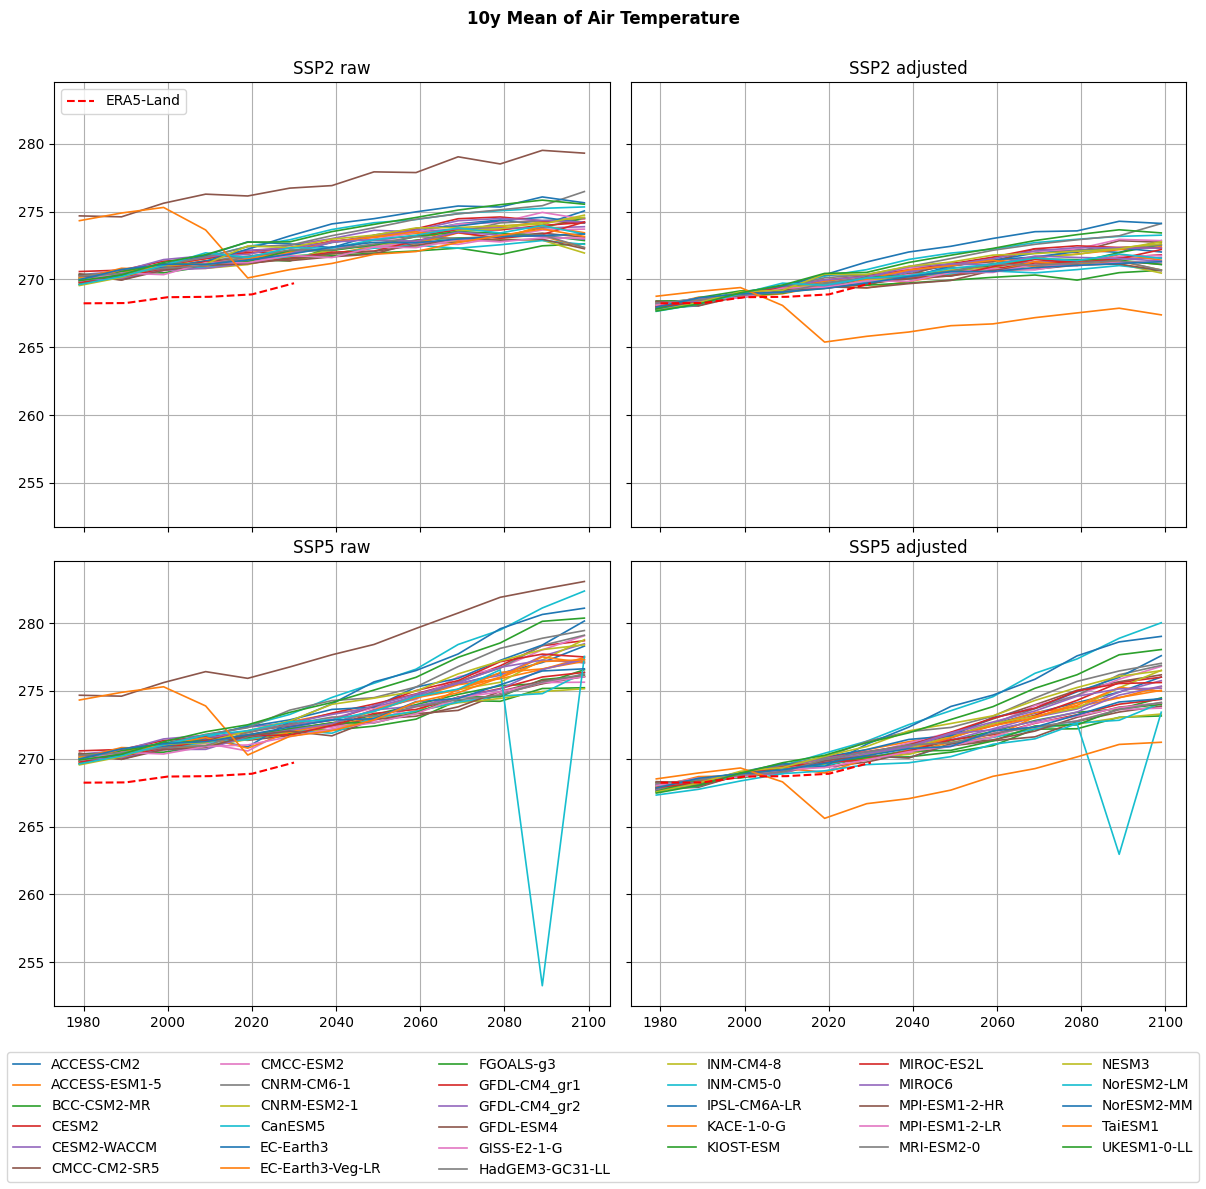

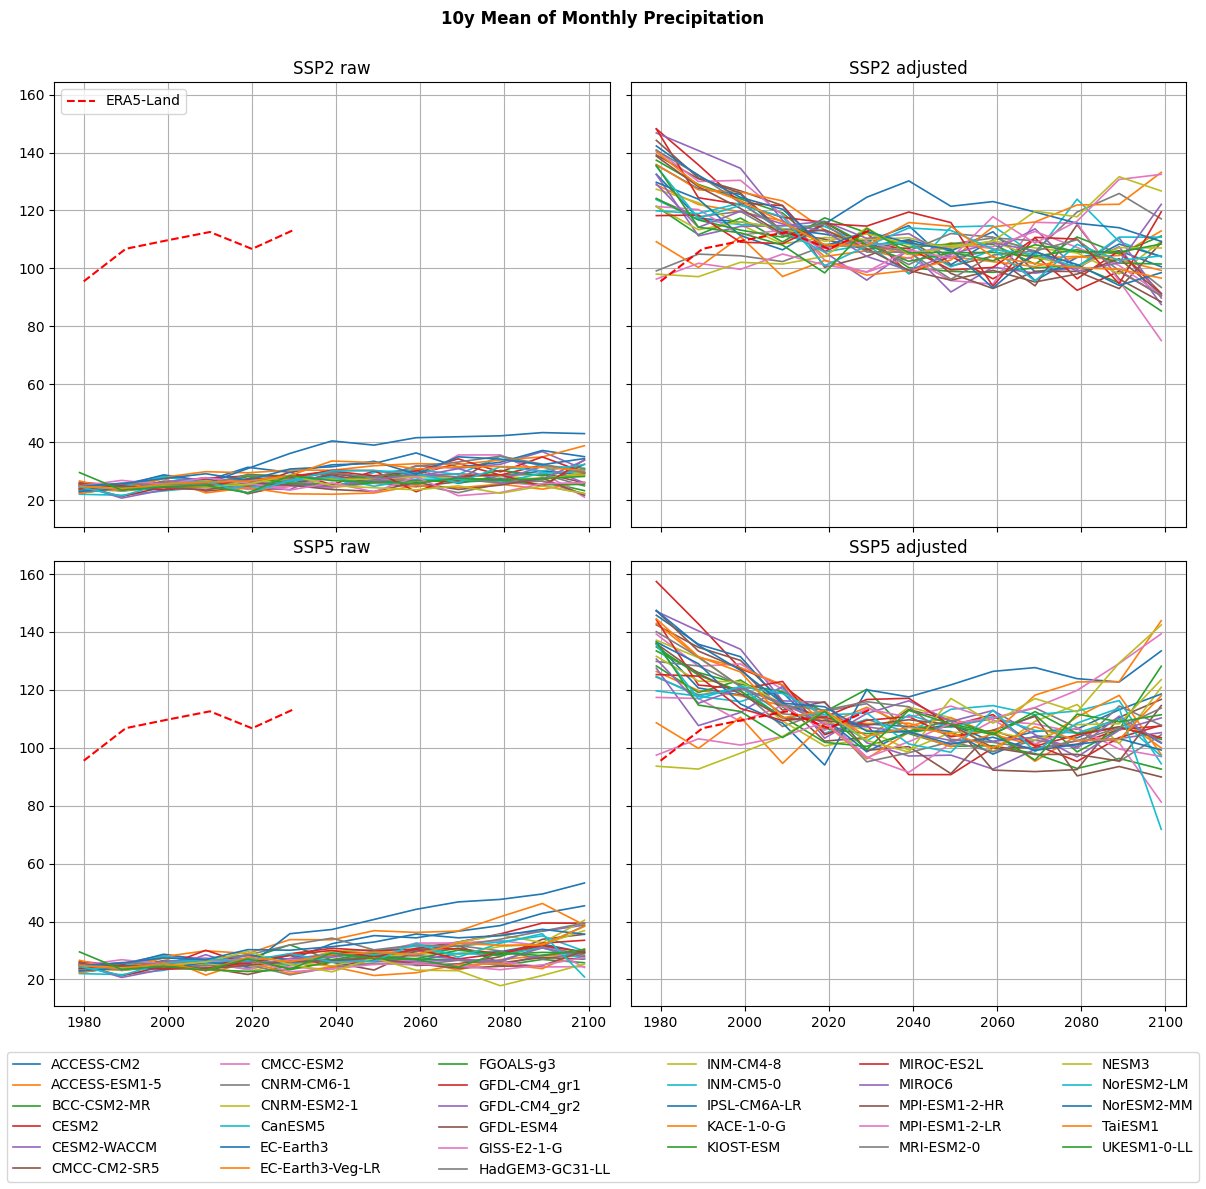

In [43]:
era5 = read_era5l(era5_file)

cmip_plot_combined(data=ssp_tas_dict, target=era5, title='10y Mean of Air Temperature', target_label='ERA5-Land', show=True, saveas='NB3_CMIP6_Temp.png')
cmip_plot_combined(data=ssp_pr_dict, target=era5, title='10y Mean of Monthly Precipitation', precip=True, target_label='ERA5-Land', show=True, intv_mean='10YE', saveas='NB3_CMIP6_Prec.png')

Apparently, some models have striking curves indicating unrealistic outliers or sudden jumps in the data. To clearly identify faulty time series, one option is to choose a qualitative approach by identifying the models using an interactive `plotly` plot. Here we can zoom and select/deselect curves as we like, to identify model names.

In [44]:
import plotly.express as px

fig = px.line(ssp5_tas_raw.resample('10YE', closed='left', label='left').mean())
fig.show()

### Violin plots

To look at it from a different perpective we can also have a look at the individual distributions of all models. A nice way to cover several aspects at once is to use `seaborne` [violinplots](https://seaborn.pydata.org/generated/seaborn.violinplot.html).

First we have to rearrange our input dictionaries a little bit. 

In [45]:
def dict_filter(dictionary, filter_string):
    """Returns a dict with all elements of the input dict that contain a filter string in their keys."""
    return {key.split('_')[0]: value for key, value in dictionary.items() if filter_string in key}


tas_raw = dict_filter(ssp_tas_dict, 'raw')
tas_adjusted = dict_filter(ssp_tas_dict, 'adjusted')
pr_raw = dict_filter(ssp_pr_dict, 'raw')
pr_adjusted = dict_filter(ssp_pr_dict, 'adjusted')

The `violinplot()` function requires input data in `long` format. 

In [132]:
def df2long(df, intv_sum='ME', intv_mean='YE', precip=False):
    """Resamples dataframes and converts them into long format to be passed to seaborn.lineplot()."""

    if precip:
        df = df.resample(intv_sum).sum().resample(intv_mean, label='left').mean()
        df = df.reset_index()
        df = df.melt('TIMESTAMP', var_name='model', value_name='prec')
    else:
        df = df.resample(intv_mean, label='left').mean()
        df = df.reset_index()
        df = df.melt('TIMESTAMP', var_name='model', value_name='temp')
    return df

For comparison the `vplots()` function will arrange the plots in a similar grid as in the figures above.

In [47]:

def vplots(before, after, target, target_label='Target', precip=False, show=False, saveas=None):
    """Creates violin plots of the kernel density estimation for all models before and after bias adjustment."""

    period = slice('1979-01-01', '2022-12-31')
    if precip:
        var = 'prec'
        var_label = 'Annual Precipitation'
        unit = ' [mm]'
    else:
        var = 'temp'
        var_label = 'Mean Annual Air Temperature'
        unit = ' [K]'
    for i in before.keys():
        before[i] = before[i].loc[period].copy()
        before[i][target_label] = target[var][period]

    for i in after.keys():
        after[i] = after[i].loc[period].copy()
        after[i][target_label] = target[var][period]

    fig = plt.figure(figsize=(20, 20))
    outer = fig.add_gridspec(1, 2)
    inner = outer[0].subgridspec(2, 1)
    axis = inner.subplots(sharex='col')

    all_data = pd.concat([df2long(before[i], precip=precip, intv_sum='YE') for i in before.keys()] +
                         [df2long(after[i], precip=precip, intv_sum='YE') for i in after.keys()])
    xmin, xmax = all_data[var].min(), all_data[var].max()

    if precip:
        xlim = (xmin * 0.95, xmax * 1.05)
    else:
        xlim = (xmin - 1, xmax +1 )

    for (i, k) in zip(before.keys(), range(0, 4, 1)):
        df = df2long(before[i], precip=precip, intv_sum='YE')
        axis[k].grid()
        sns.violinplot(ax=axis[k], x=var, y='model', data=df, density_norm="count", bw_adjust=.2)
        axis[k].set(xlim=xlim)
        axis[k].set_ylabel(i, fontsize=18, fontweight='bold')
        if k == 0:
            axis[k].set_title('Before Scaled Distribution Mapping', fontweight='bold', fontsize=18)
    plt.xlabel(var_label + unit)

    inner = outer[1].subgridspec(2, 1)
    axis = inner.subplots(sharex='col')
    for (i, k) in zip(after.keys(), range(0, 4, 1)):
        df = df2long(after[i], precip=precip, intv_sum='YE')
        axis[k].grid()
        sns.violinplot(ax=axis[k], x=var, y='model', data=df, density_norm="count", bw_adjust=.2)
        axis[k].set(xlim=xlim)
        axis[k].set_ylabel(i, fontsize=18, fontweight='bold')
        axis[k].get_yaxis().set_visible(False)
        if k == 0:
            axis[k].set_title('After Scaled Distribution Mapping', fontweight='bold', fontsize=18)
    plt.xlabel(var_label + unit)

    starty = period.start.split('-')[0]
    endy = period.stop.split('-')[0]
    fig.suptitle('Kernel Density Estimation of ' + var_label + ' (' + starty + '-' + endy + ')',
                 fontweight='bold', fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=0.93)
    if saveas is not None:
        plt.savefig(dir_figures + saveas)
    if show:
        plt.show()

Again, we run the plotting function for every variable individually.

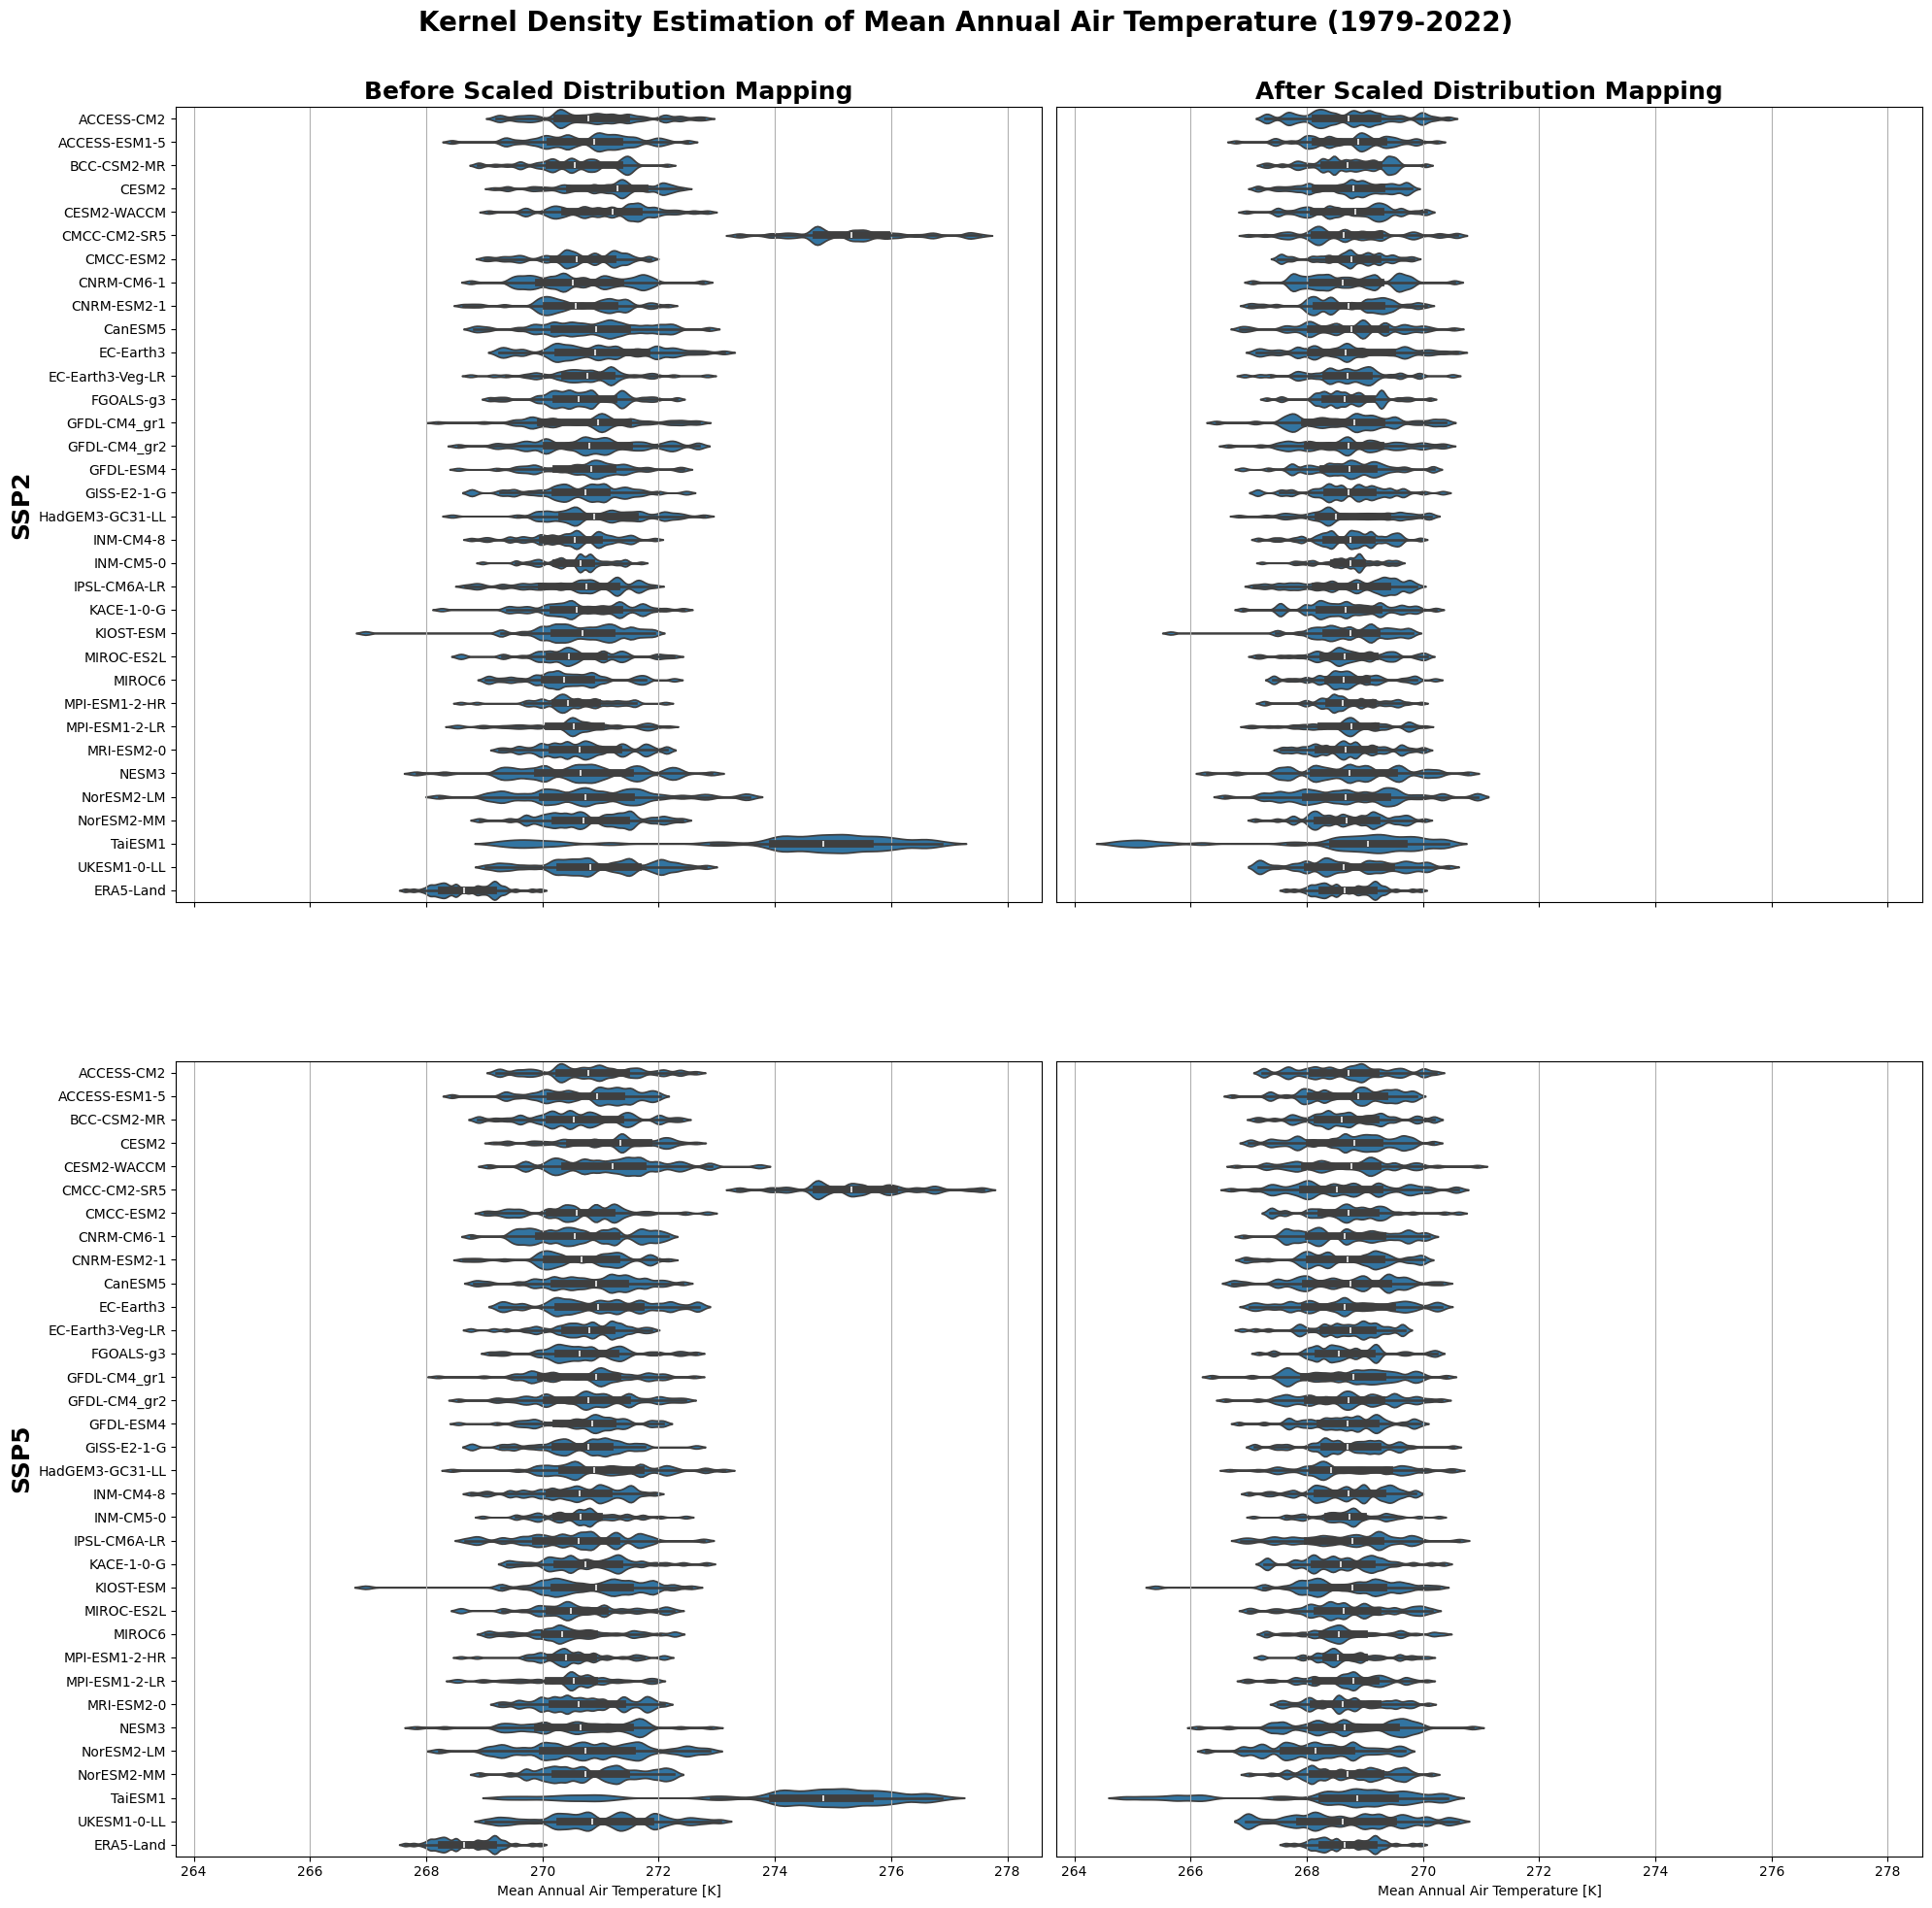

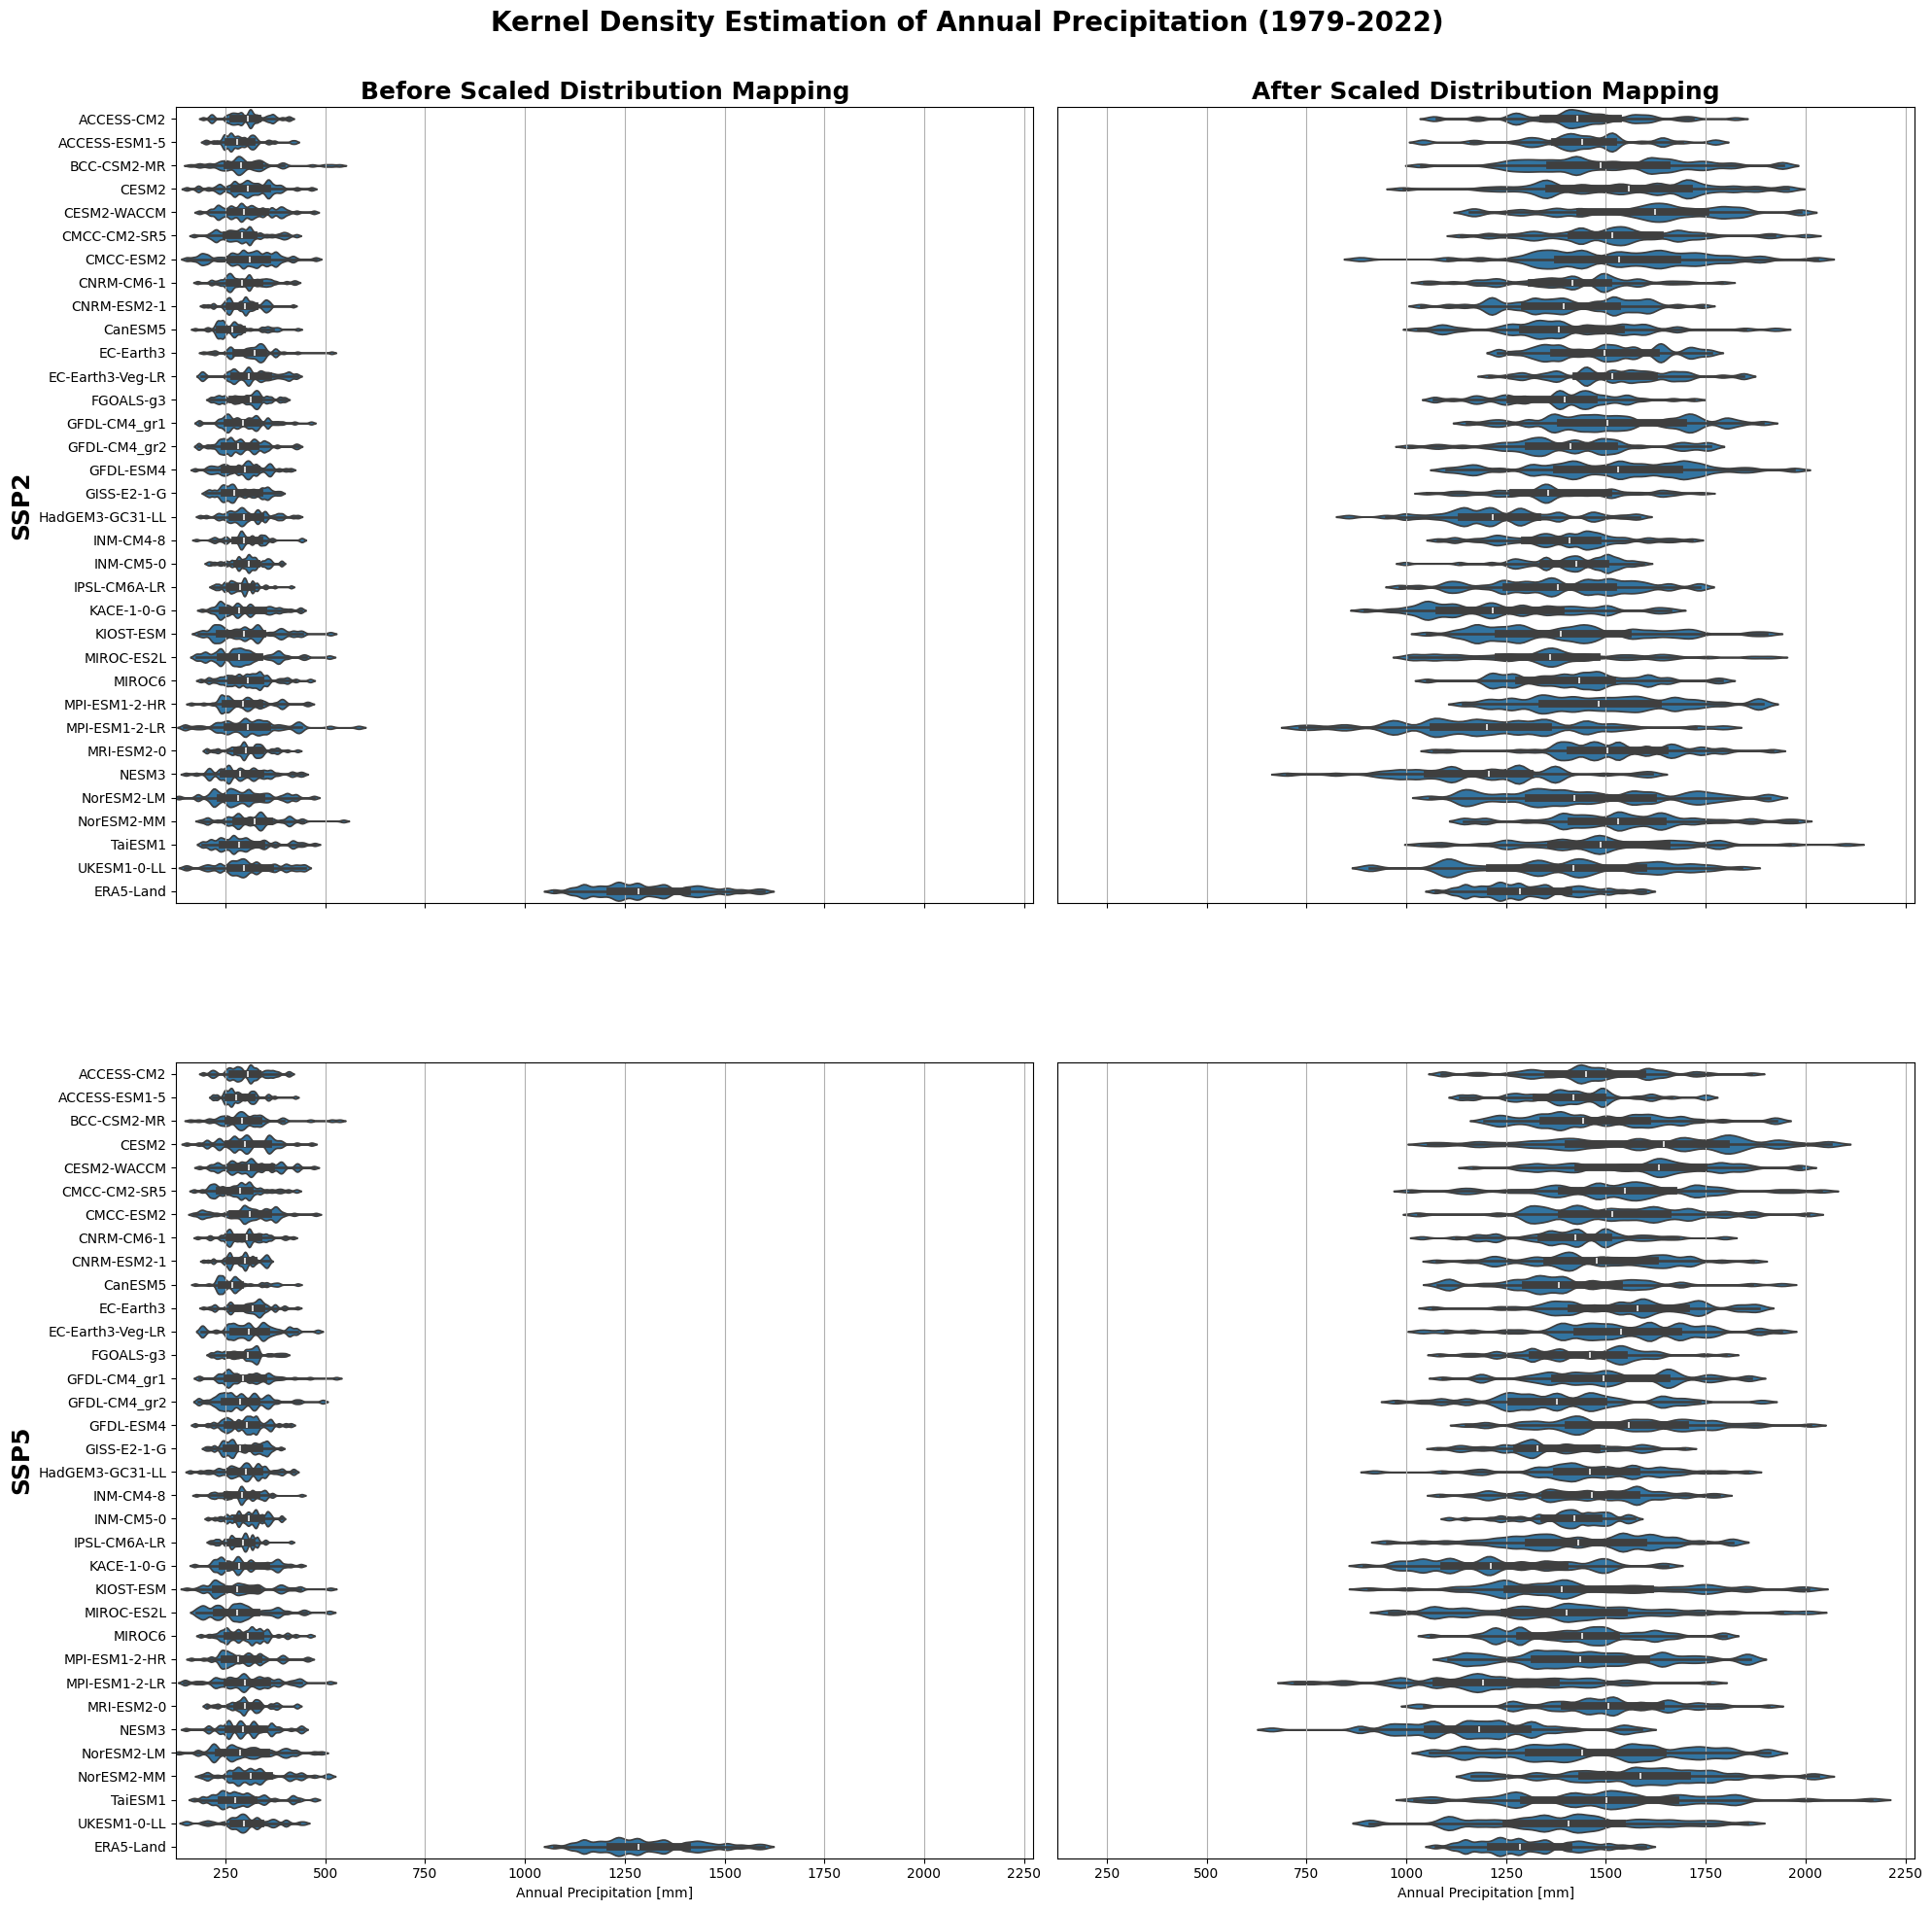

In [48]:
vplots(tas_raw, tas_adjusted, era5, target_label='ERA5-Land', show=True, saveas='NB3_vplot_Temp.png')
vplots(pr_raw, pr_adjusted, era5, target_label='ERA5-Land', precip=True, show=True, saveas='NB3_vplot_Prec.png')

### Data filters

Alternatively, we can create some helper functions to remove respective models automatically and combine them in a handy class. 

In [49]:
class DataFilter:
    def __init__(self, df, zscore_threshold=3, resampling_rate=None, prec=False, jump_threshold=5):
        self.df = df
        self.zscore_threshold = zscore_threshold
        self.resampling_rate = resampling_rate
        self.prec = prec
        self.jump_threshold = jump_threshold
        self.filter_all()


    def check_outliers(self):
        """
        A function for filtering a pandas dataframe for columns with obvious outliers
        and dropping them based on a z-score threshold.

        Returns
        -------
        models : list
            A list of columns identified as having outliers.
        """
        # Resample if rate specified
        if self.resampling_rate is not None:
            if self.prec:
                self.df = self.df.resample(self.resampling_rate).sum()
            else:
                self.df = self.df.resample(self.resampling_rate).mean()

        # Calculate z-scores for each column
        z_scores = pd.DataFrame((self.df - self.df.mean()) / self.df.std())

        # Identify columns with at least one outlier (|z-score| > threshold)
        cols_with_outliers = z_scores.abs().apply(lambda x: any(x > self.zscore_threshold))
        self.outliers = list(self.df.columns[cols_with_outliers])

        # Return the list of columns with outliers
        return self.outliers

    def check_jumps(self):
        """
        A function for checking a pandas dataframe for columns with sudden jumps or drops
        and returning a list of the columns that have them.

        Returns
        -------
        jumps : list
            A list of columns identified as having sudden jumps or drops.
        """
        cols = self.df.columns
        jumps = []

        for col in cols:
            diff = self.df[col].diff()
            if (abs(diff) > self.jump_threshold).any():
                jumps.append(col)

        self.jumps = jumps
        return self.jumps

    def filter_all(self):
        """
        A function for filtering a dataframe for columns with obvious outliers
        or sudden jumps or drops in temperature, and returning a list of the
        columns that have been filtered using either or both methods.

        Returns
        -------
        filtered_models : list
            A list of columns identified as having outliers or sudden jumps/drops in temperature.
        """
        self.check_outliers()
        self.check_jumps()
        self.filtered_models = list(set(self.outliers) | set(self.jumps))
        return self.filtered_models

By default the `DataFilter` class filters models containing ...

  ... outliers deviating more than 3 standard deviations from the mean (`zscore_threshold`) and/or ...

  ... increases/decreases of more than 5 units in a single timestep (`jump_threshold`).

The functions can be applied separately (`check_outliers` or `check_jumps`) or together (`filter_all`). All three return a `list` of model names.

Here, we also use the `resampling_rate` parameter to resample the data to annual means (`'YE'`) before running the checks.

In [50]:
filter = DataFilter(ssp5_tas_raw, zscore_threshold=3, jump_threshold=5, resampling_rate='YE')

print('Models with temperature outliers: ' + str(filter.outliers))
print('Models with temperature jumps: ' + str(filter.jumps))
print('Models with either one or both: ' + str(filter.filtered_models))

Models with temperature outliers: ['NorESM2-LM']
Models with temperature jumps: ['NorESM2-LM', 'TaiESM1']
Models with either one or both: ['NorESM2-LM', 'TaiESM1']


The identified columns can then be removed from the CMIP6 ensemble dataset using another helper function.

In [51]:
def drop_model(col_names, dict_or_df):
    """
    Drop columns with given names from either a dictionary of dataframes
    or a single dataframe.
    Parameters
    ----------
    col_names : list of str
        The list of model names to drop.
    dict_or_df : dict of pandas.DataFrame or pandas.DataFrame
        If a dict of dataframes, all dataframes in the dict will be edited.
        If a single dataframe, only that dataframe will be edited.
    Returns
    -------
    dict_of_dfs : dict of pandas.DataFrame or pandas.DataFrame
        The updated dictionary of dataframes or dataframe with dropped columns.
    """
    if isinstance(dict_or_df, dict):
        # loop through the dictionary and edit each dataframe
        for key in dict_or_df.keys():
            if all(col_name in dict_or_df[key].columns for col_name in col_names):
                dict_or_df[key] = dict_or_df[key].drop(columns=col_names)
        return dict_or_df
    elif isinstance(dict_or_df, pd.DataFrame):
        # edit the single dataframe
        if all(col_name in dict_or_df.columns for col_name in col_names):
            return dict_or_df.drop(columns=col_names)
    else:
        raise TypeError('Input must be a dictionary or a dataframe')

We run the `drop_model()` function on the dictionaries of all variables and run `cmip_plot_combined()` again to check the result.

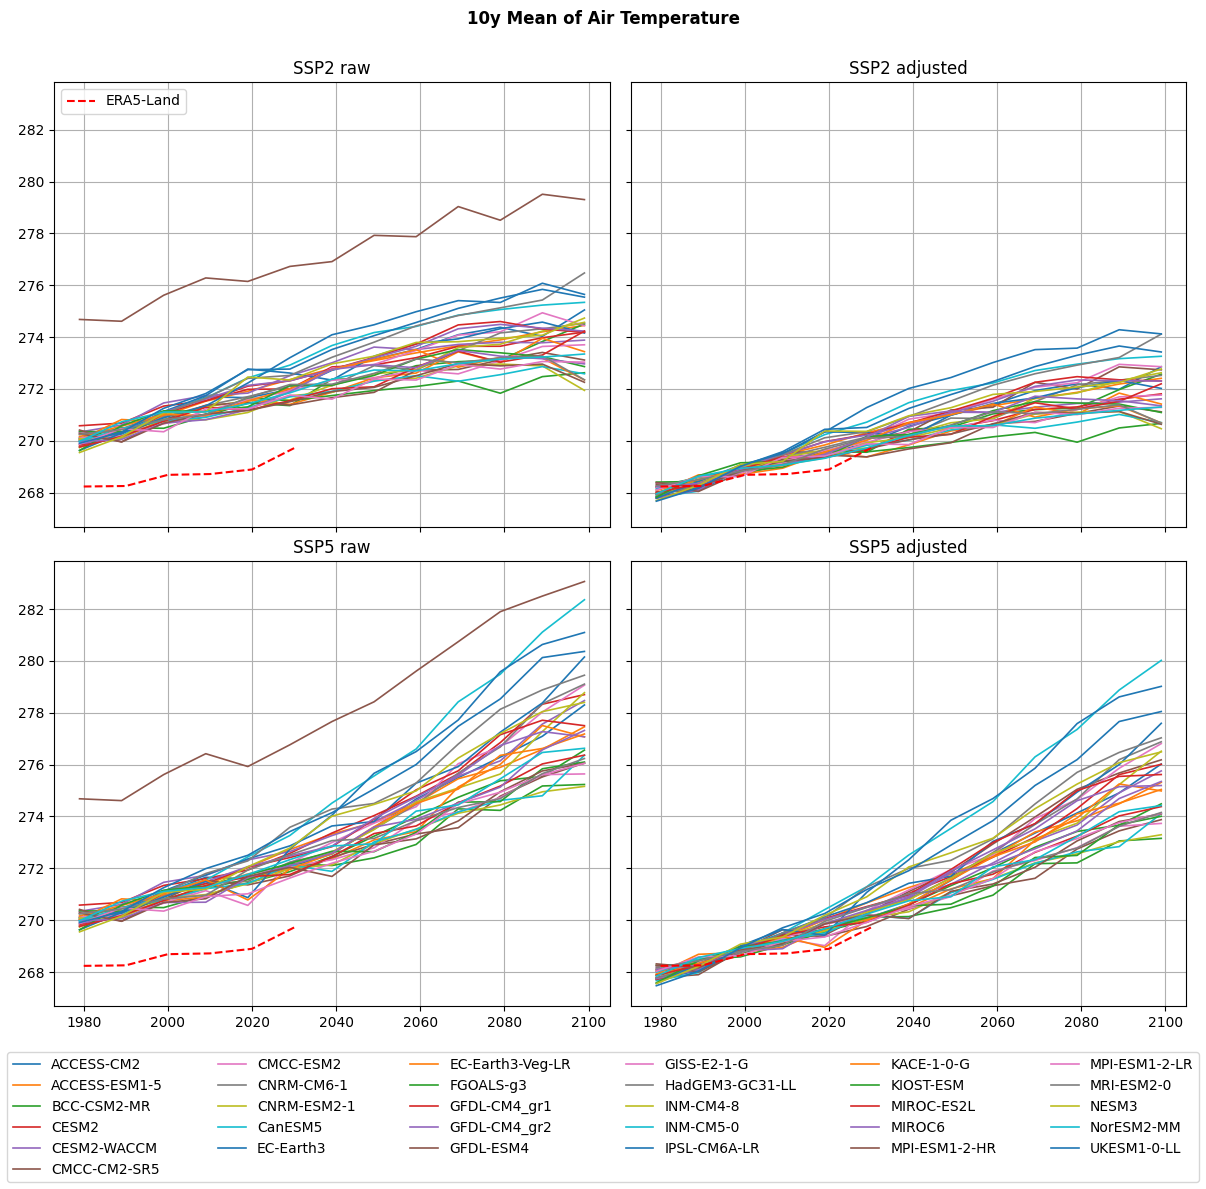

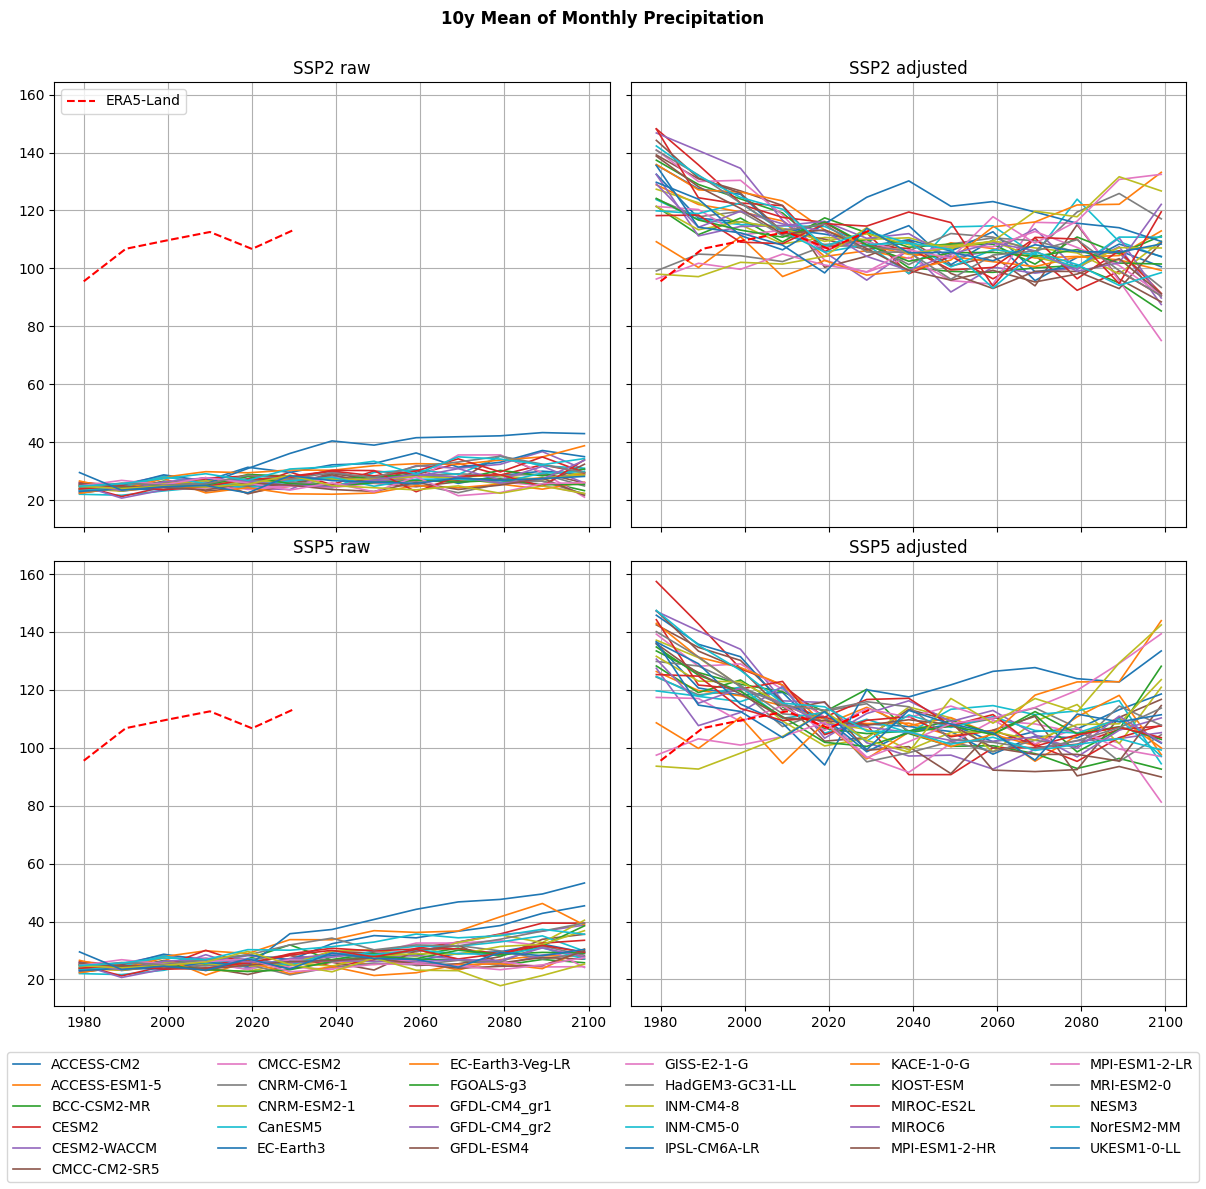

In [52]:
ssp_tas_dict = drop_model(filter.filtered_models, ssp_tas_dict)
ssp_pr_dict = drop_model(filter.filtered_models, ssp_pr_dict)


cmip_plot_combined(data=ssp_tas_dict, target=era5, title='10y Mean of Air Temperature', target_label='ERA5-Land', show=True, saveas='NB3_CMIP6_Temp_filtered.png')
cmip_plot_combined(data=ssp_pr_dict, target=era5, title='10y Mean of Monthly Precipitation', precip=True, target_label='ERA5-Land', show=True, intv_mean='10YE', saveas='NB3_CMIP6_Prec_filtered.png')

### Ensemble mean plots

As we now don't need to focus on individual models anymore, we can reduce the number of lines by only plotting the ensemble means with a 90% confidence interval.

In [137]:
import warnings
from matplotlib.legend import Legend
sns.set_style("white")
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['text.usetex'] = True




def cmip_plot_ensemble(cmip, target, precip=False, intv_sum='ME', intv_mean='YE', figsize=(8, 6), show=True, saveas=None):
    """
    Plots the multi-model mean of climate scenarios including the 90% confidence interval.
    Parameters
    ----------
    cmip: dict
        A dictionary with keys representing the different CMIP6 models and scenarios as pandas dataframes
        containing data of temperature and/or precipitation.
    target: pandas.DataFrame
        Dataframe containing the historical reanalysis data.
    precip: bool
        If True, plot the mean precipitation. If False, plot the mean temperature. Default is False.
    intv_sum: str
        Interval for precipitation sums. Default is monthly ('ME').
    intv_mean: str
        Interval for the mean of temperature data or precipitation sums. Default is annual ('YE').
    figsize: tuple
        Figure size for the plot. Default is (8,6).
    show: bool
        If True, show the resulting plot. If False, do not show it. Default is True.
    """

    warnings.filterwarnings(action='ignore')
    figure, axis = plt.subplots(figsize=figsize, constrained_layout=True)

    # Define color palette
    colors = ['darkorange', 'orange', 'darkblue', 'dodgerblue']
    # create a new dictionary with the same keys but new values from the list
    col_dict = {key: value for key, value in zip(cmip.keys(), colors)}
    
    #figure.tight_layout(rect=[0, 0.02, 1, 0.95])  # Make some room at the bottom

    if precip:
        for i in cmip.keys():
            df = df2long(cmip[i], intv_sum=intv_sum, intv_mean=intv_mean, precip=True)
            sns.lineplot(data=df, x='TIMESTAMP', y='prec', color=col_dict[i])
        axis.set(xlabel=None, ylabel='[mm]')
        if intv_sum=='ME':
            figure.suptitle('Mean Monthly Precipitation', fontweight='bold', fontsize=16)
        elif intv_sum=='YE':
            figure.suptitle('Mean Annual Precipitation', fontweight='bold', fontsize=16)
        target_plot = axis.plot(target.resample(intv_sum).sum().resample(intv_mean).mean(), linewidth=1.5, c='black',
                             label='ERA5', linestyle='dashed')
    else:
        for i in cmip.keys():
            df = df2long(cmip[i], intv_mean=intv_mean)
            sns.lineplot(data=df, x='TIMESTAMP', y='temp', color=col_dict[i])
        axis.set(xlabel=None, ylabel='[K]')
        if intv_mean=='10YE':
            figure.suptitle('Mean 10y Air Temperature', fontweight='bold', fontsize=16)
        elif intv_mean == 'YE':
            figure.suptitle('Mean Annual Air Temperature', fontweight='bold', fontsize=16)
        elif intv_mean == 'ME':
            figure.suptitle('Mean Monthly Air Temperature', fontweight='bold', fontsize=16)
        target_plot = axis.plot(target.resample(intv_mean).mean(), linewidth=1.5, c='black',
                         label='ERA5', linestyle='dashed')
    axis.legend(['SSP2 raw', '_ci1', 'SSP2 adjusted', '_ci2', 'SSP5 raw', '_ci3', 'SSP5 adjusted', '_ci4'],
                loc="upper center", bbox_to_anchor=(0.39, -0.14), ncol=4,
                frameon=False)  # First legend --> Workaround as seaborn lists CIs in legend
    leg = Legend(axis, target_plot, ['ERA5L'], loc='upper center', bbox_to_anchor=(0.89, -0.14), ncol=1,
                 frameon=False)  # Second legend (ERA5)
    axis.add_artist(leg)
    axis.grid(True, linestyle='--', alpha=0.7)  # Dashed lines with transparency
    axis.margins(x=0.001)
    
    if saveas is not None:
        plt.savefig(dir_figures+saveas)
    if show:
        plt.show()
    warnings.filterwarnings(action='always')



With less lines in the plot, we can also reduce the resample frequency and show annual means.

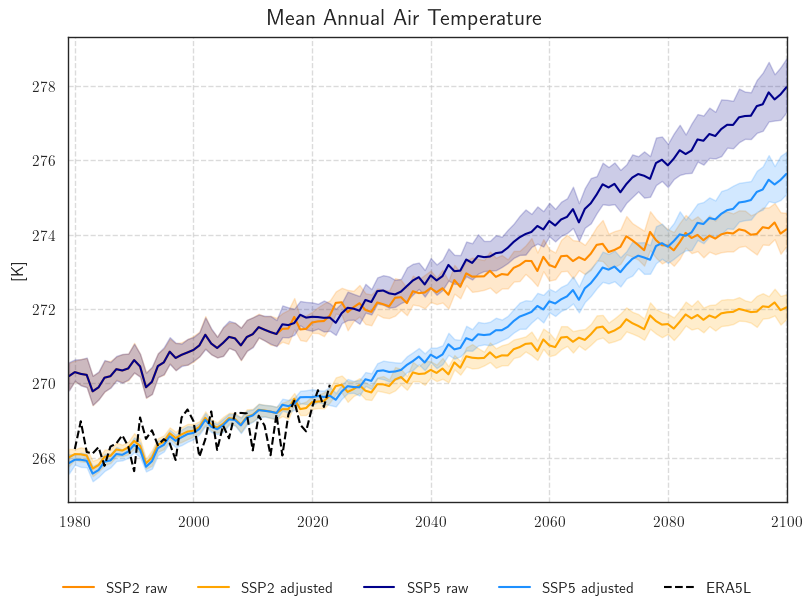

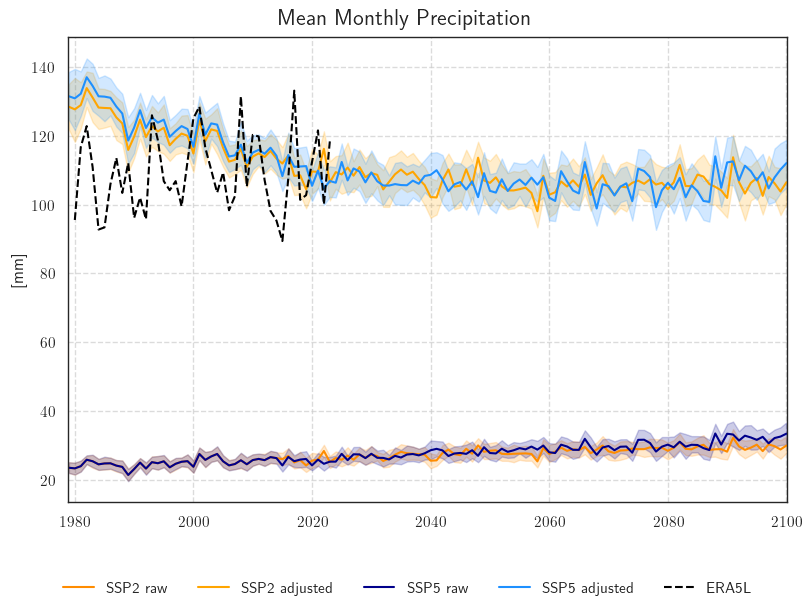

In [138]:
cmip_plot_ensemble(ssp_tas_dict, era5['temp'], intv_mean='YE', saveas='NB3_CMIP6_Ensemble_Temp.png')
cmip_plot_ensemble(ssp_pr_dict, era5['prec'], precip=True, intv_sum='ME', intv_mean='YE', saveas='NB3_CMIP6_Ensemble_Prec.png')

We can see that the SDM adjusts the range and mean of the target data while preserving the distribution and trend of the original data. However, the inter-model variance is slightly reduced for temperature and significantly increased for precipitation.

Last but not least, we will have a closer look at the performance of the bias adjustment. To do that, we will create probability plots for all models comparing original, target, and adjusted data with each other and a standard normal distribution. The `prob_plot` function creates such a plot for an individual model and scenario. The `pp_matrix` function loops the `prob_plot` function over all models in a `DataFrame` and arranges them in a matrix.

In [55]:
import probscale

def prob_plot(original, target, corrected, ax, title=None, ylabel="Temperature [K]", **kwargs):
    """
    Combines probability plots of climate model data before and after bias adjustment
    and the target data.

    Parameters
    ----------
    original : pandas.DataFrame
        The original climate model data.
    target : pandas.DataFrame
        The target data.
    corrected : pandas.DataFrame
        The climate model data after bias adjustment.
    ax : matplotlib.axes.Axes
        The axes on which to plot the probability plot.
    title : str, optional
        The title of the plot. Default is None.
    ylabel : str, optional
        The label for the y-axis. Default is "Temperature [K]".
    **kwargs : dict, optional
        Additional keyword arguments passed to the probscale.probplot() function.

    Returns
    -------
    fig : matplotlib Figure
        The generated figure.
    """

    scatter_kws = dict(label="", marker=None, linestyle="-")
    common_opts = dict(plottype="qq", problabel="", datalabel="", **kwargs)

    scatter_kws["label"] = "original"
    fig = probscale.probplot(original, ax=ax, scatter_kws=scatter_kws, **common_opts)

    scatter_kws["label"] = "target"
    fig = probscale.probplot(target, ax=ax, scatter_kws=scatter_kws, **common_opts)

    scatter_kws["label"] = "adjusted"
    fig = probscale.probplot(corrected, ax=ax, scatter_kws=scatter_kws, **common_opts)

    ax.set_title(title)

    ax.set_xlabel("Standard Normal Quantiles")
    ax.set_ylabel(ylabel)
    ax.grid(True)

    score = round(target.corr(corrected), 2)
    ax.text(0.05, 0.8, f"R² = {score}", transform=ax.transAxes, fontsize=15)

    return fig


def pp_matrix(original, target, corrected, scenario=None, nrow=7, ncol=5, precip=False, show=False, saveas=None):
    """
    Arranges the prob_plots of all CMIP6 models in a matrix and adds the R² score.

    Parameters
    ----------
    original : pandas.DataFrame
        The original climate model data.
    target : pandas.DataFrame
        The target data.
    corrected : pandas.DataFrame
        The climate model data after bias adjustment.
    scenario : str, optional
        The climate scenario to be added to the plot title.
    nrow : int, optional
        The number of rows in the plot matrix. Default is 7.
    ncol : int, optional
        The number of columns in the plot matrix. Default is 5.
    precip : bool, optional
        Indicates whether the data is precipitation data. Default is False.
    show : bool, optional
        Indicates whether to display the plot. Default is False.

    Returns
    -------
    None
    """

    period = slice('1979-01-01', '2022-12-31')
    if precip:
        var = 'Precipitation'
        var_label = 'Monthly ' + var
        unit = ' [mm]'
        original = original.resample('ME').sum()
        target = target.resample('ME').sum()
        corrected = corrected.resample('ME').sum()
    else:
        var = 'Temperature'
        var_label = 'Daily Mean ' + var
        unit = ' [K]'

    fig = plt.figure(figsize=(16, 16))

    for i, col in enumerate(original.columns):
        ax = plt.subplot(nrow, ncol, i + 1)
        prob_plot(original[col][period], target[period],
                  corrected[col][period], ax=ax, ylabel=var + unit)
        ax.set_title(col, fontweight='bold')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, ['original (CMIP6 raw)', 'target (ERA5-Land)', 'adjusted (CMIP6 after SDM)'], loc='lower right',
               bbox_to_anchor=(0.96, 0.024), fontsize=20)
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.7, wspace=0.4)
    starty = period.start.split('-')[0]
    endy = period.stop.split('-')[0]
    if scenario is None:
        fig.suptitle('Probability Plots of CMIP6 and ERA5-Land ' + var_label + ' (' + starty + '-' + endy + ')',
                 fontweight='bold', fontsize=20)
    else:
        fig.suptitle('Probability Plots of CMIP6 (' + scenario + ') and ERA5-Land ' + var_label +
                     ' (' + starty + '-' + endy + ')', fontweight='bold', fontsize=20)
    plt.subplots_adjust(top=0.93)
    if saveas is not None:
        plt.savefig(dir_figures+saveas)
    if show:
        plt.show()

First we'll have a look at the temperature.

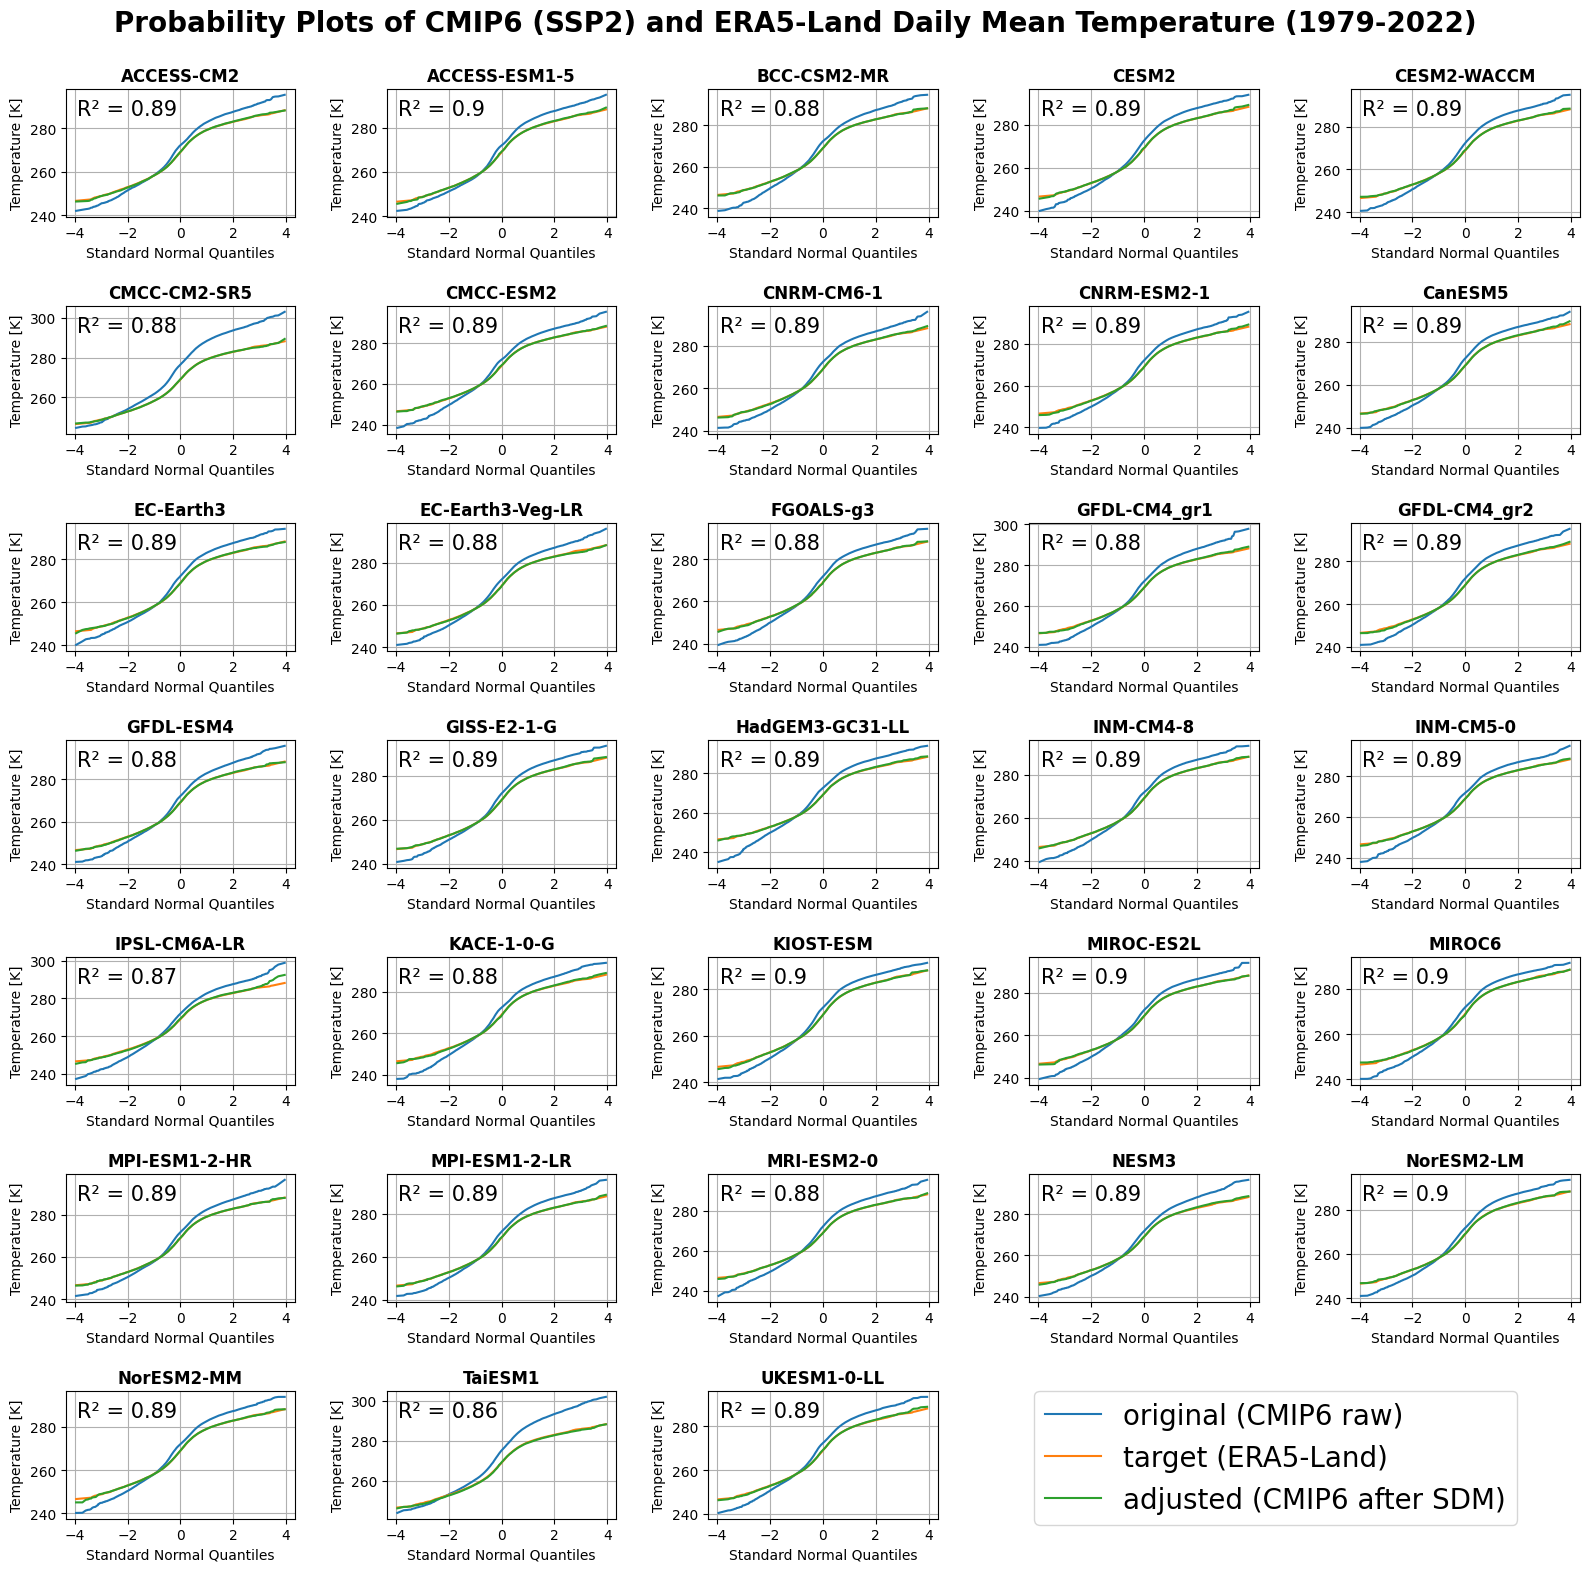

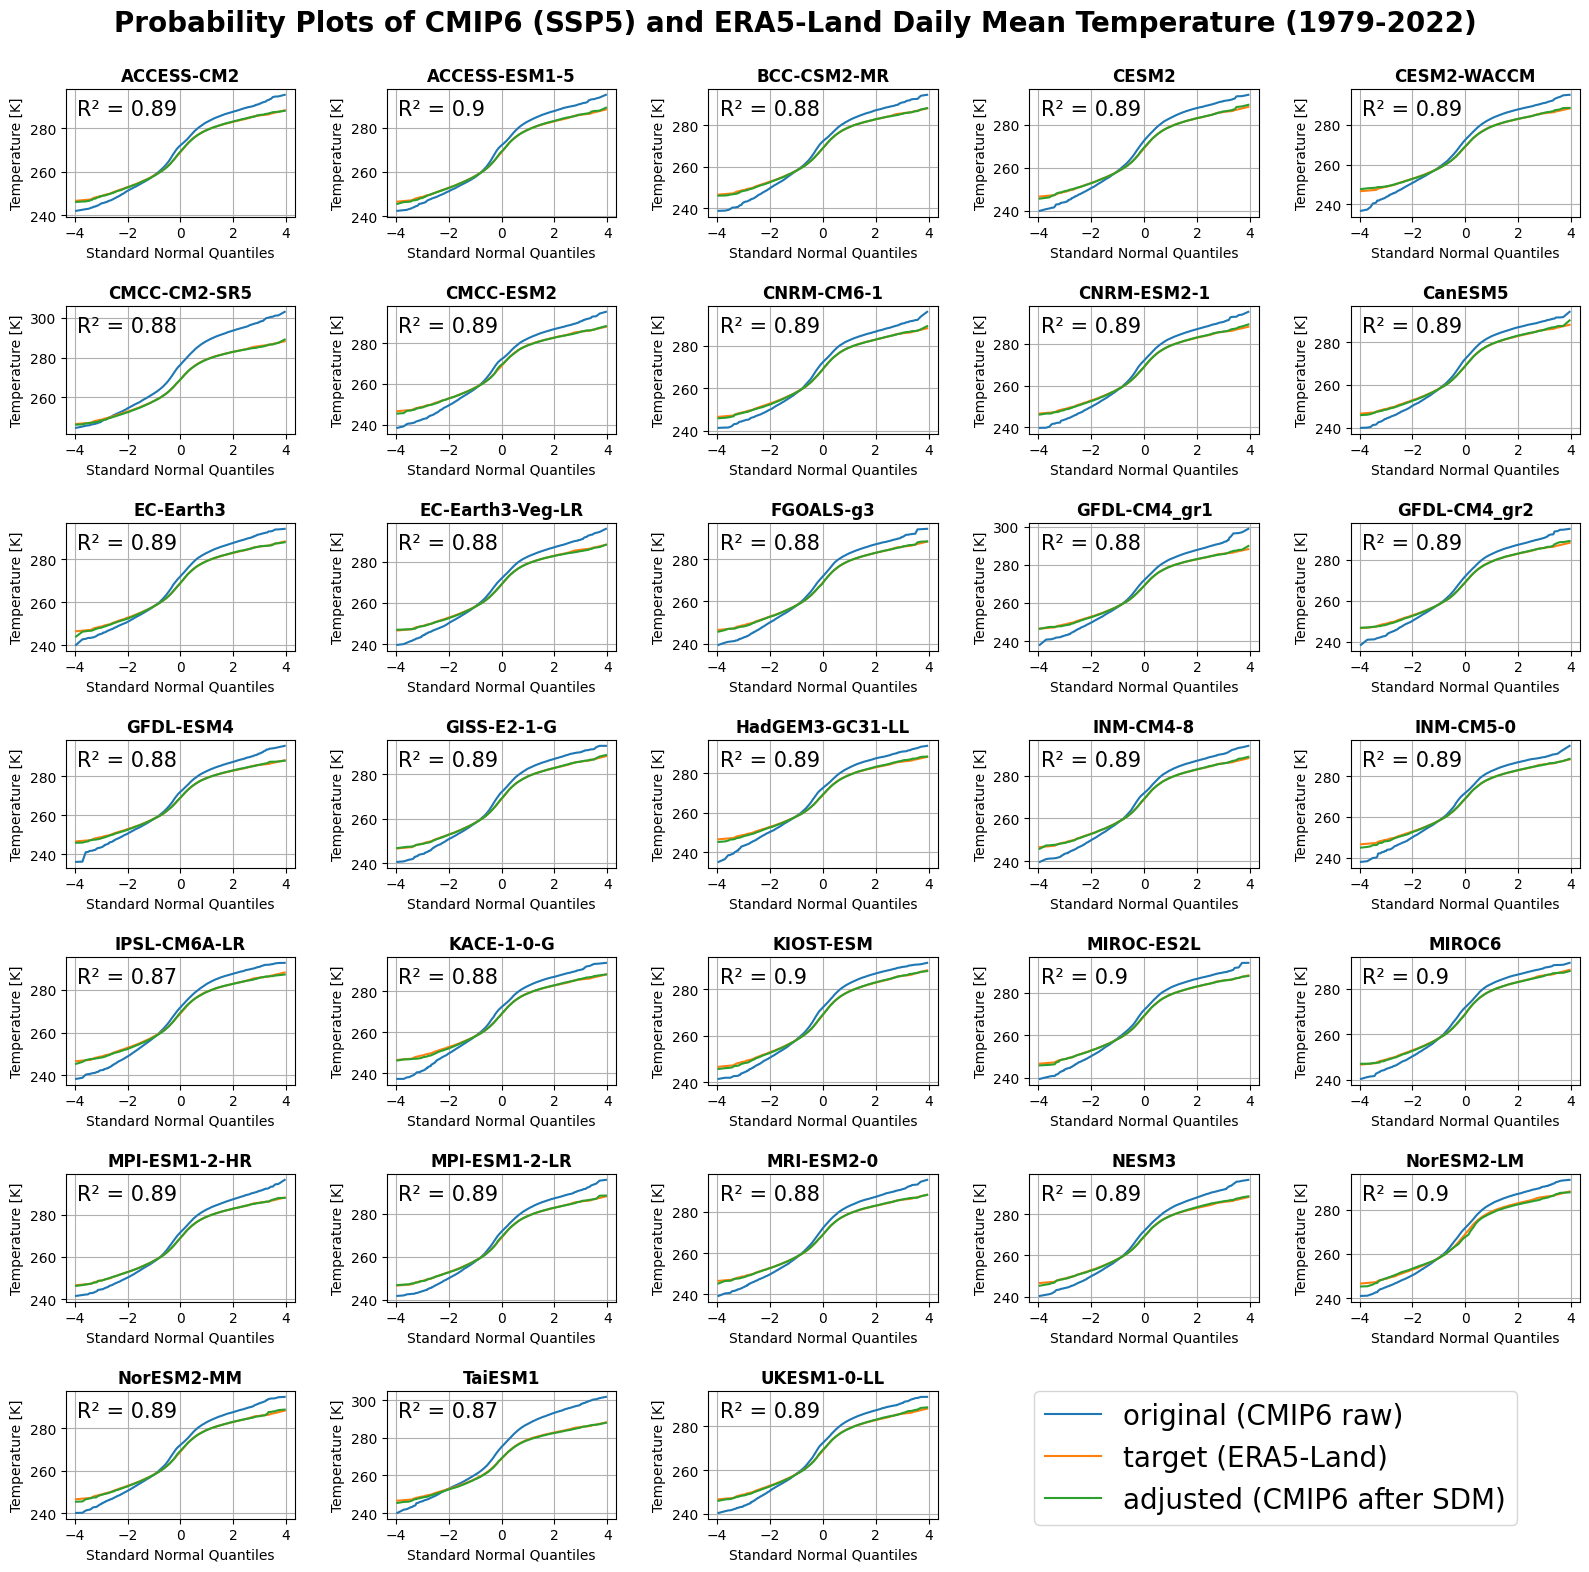

In [56]:
pp_matrix(ssp2_tas_raw, era5['temp'], ssp2_tas, scenario='SSP2', show=True, saveas='NB3_CMIP6_SSP2_probability_Temp.png')
pp_matrix(ssp5_tas_raw, era5['temp'], ssp5_tas, scenario='SSP5', show=True, saveas='NB3_CMIP6_SSP5_probability_Temp.png')

We can see that the SDM worked very well for the temperature data, with high agreement between the target and adjusted data.

Let's look at the probability curves for precipitation. Since the precipitation data is bounded at 0, but most days have very small values >0 mm, we resample the data to monthly sums to get an idea of the overall performance.

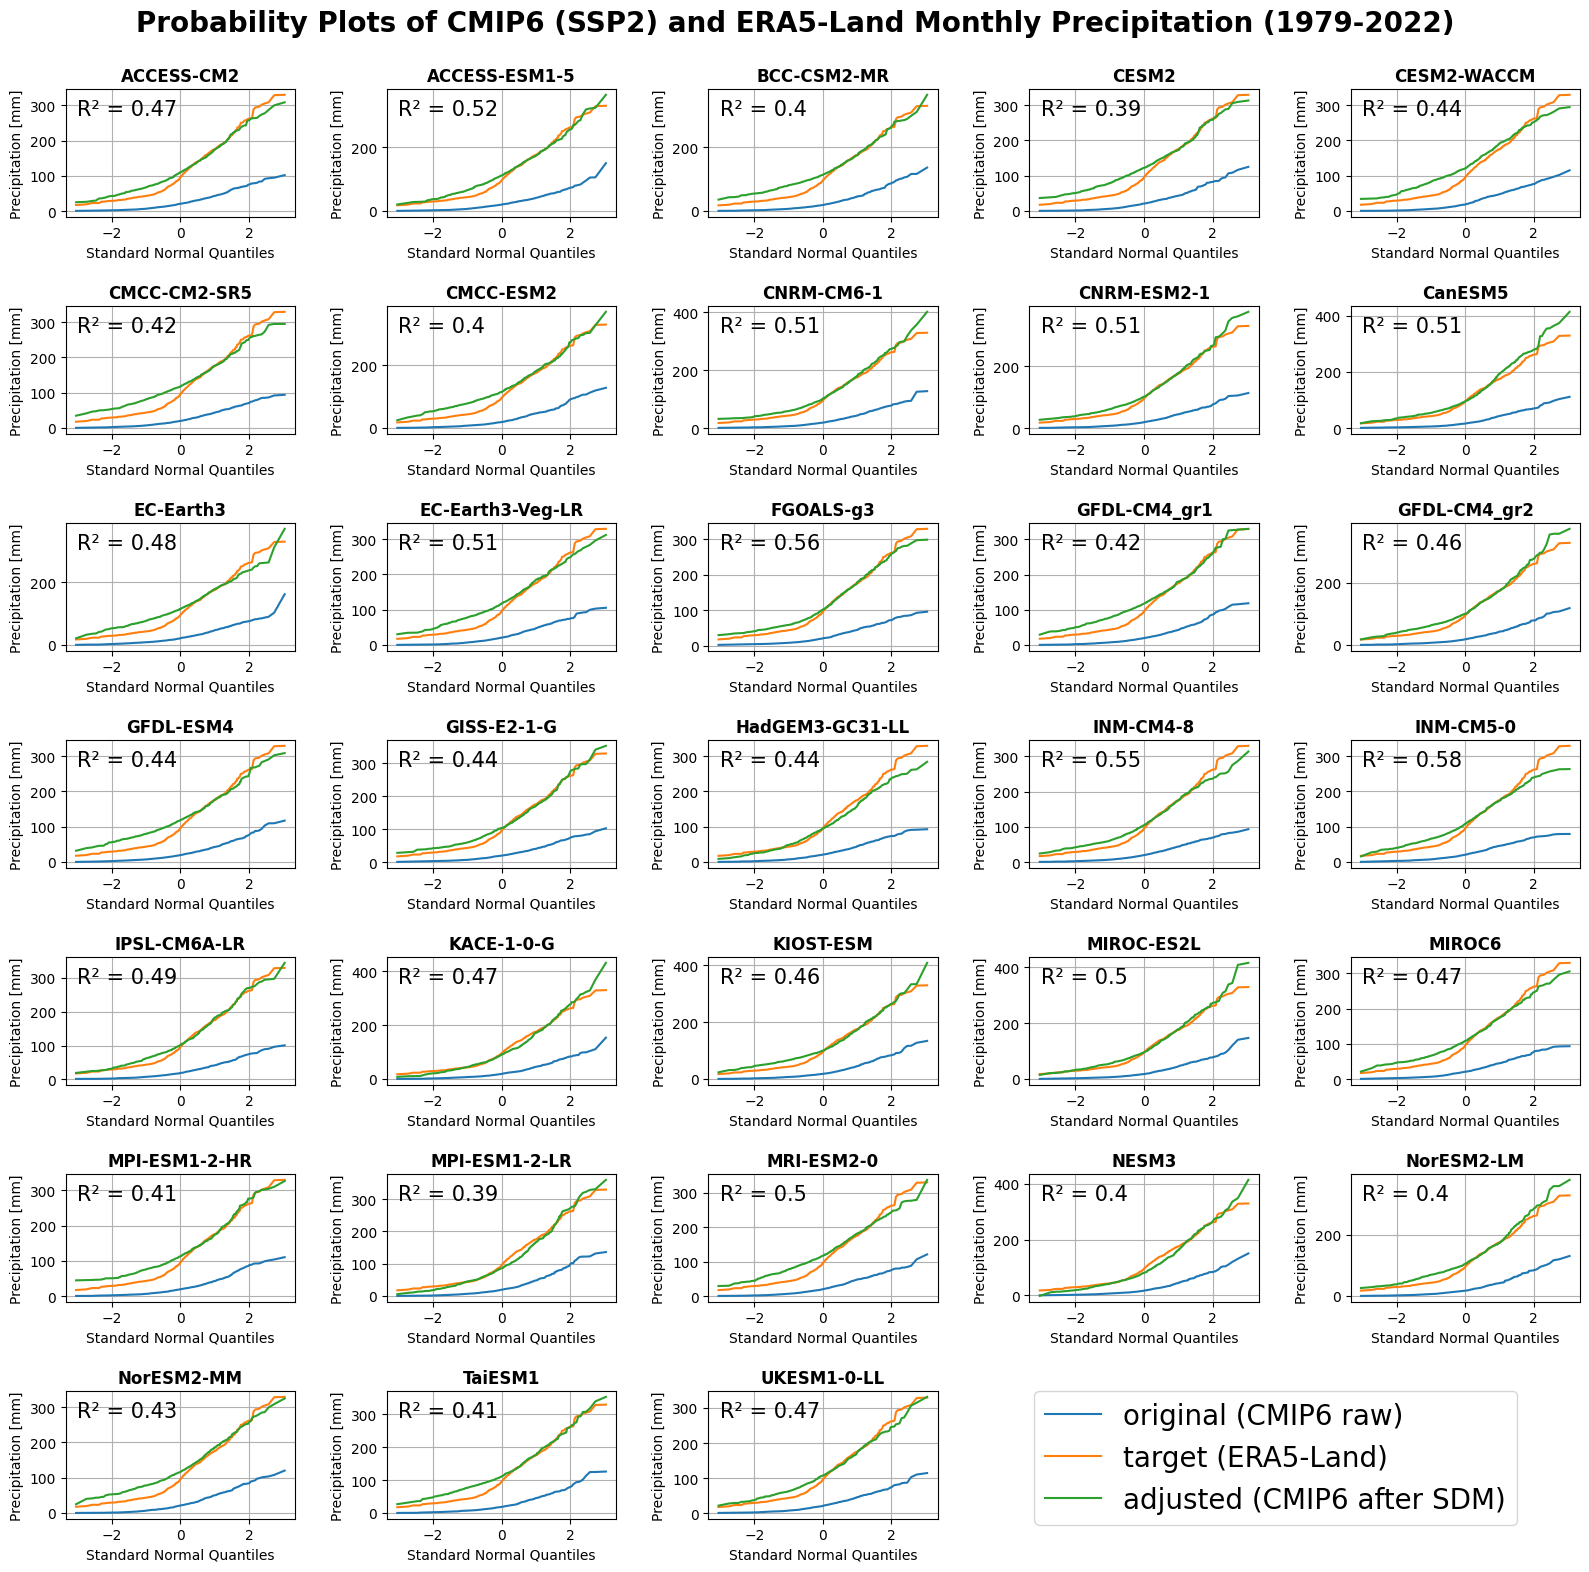

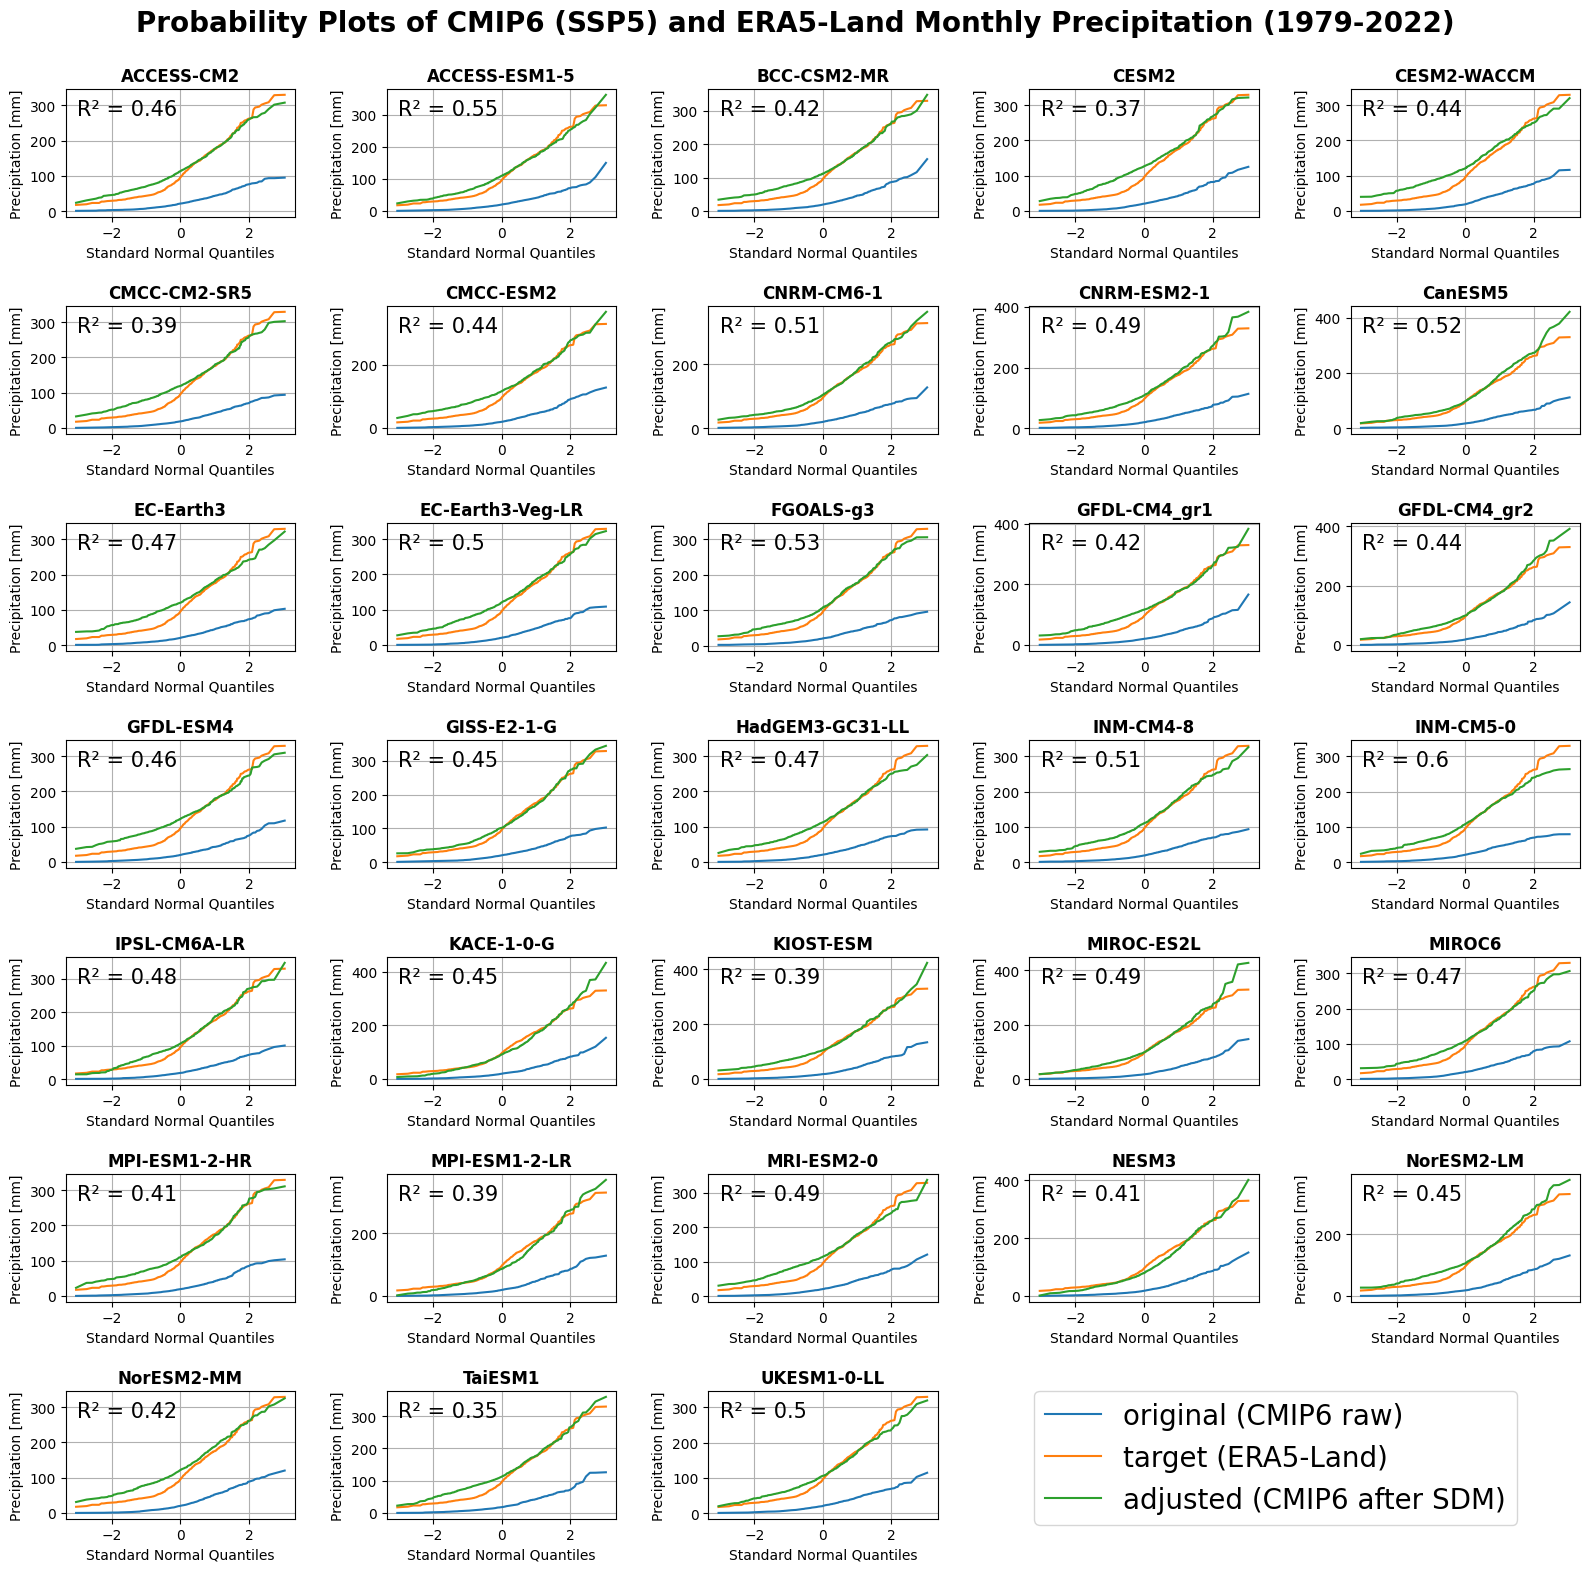

In [57]:
pp_matrix(ssp2_pr_raw, era5['prec'], ssp2_pr, precip=True, scenario='SSP2', show=True, saveas='NB3_CMIP6_SSP2_probability_Prec.png')
pp_matrix(ssp5_pr_raw, era5['prec'], ssp5_pr, precip=True, scenario='SSP5', show=True, saveas='NB3_CMIP6_SSP5_probability_Prec.png')

Considering the complexity and heterogeneity of precipitation data, the performance of SDM is convincing. While the fitted data of most models deviate from the target data for low and very high values, the general distribution of monthly precipitation is well met. 

## Write CMIP6 data to file

After a thorough review of the climate scenario data, we can write the final selection to files for use in the next notebook. Since the whole ensemble results in relatively large files, we store the dictionaries in binary files. These are not human readable, but compact and fast to read and write.

<div class="alert alert-block alert-info">
<b>Note:</b> In the config file you can choose between two storage options: <code>pickle</code> files are fast to read and write, but take up more disk space (<code>COMPACT_FILES = False</code>). You can use them on your local machine. <code>parquet</code> files need less disk space but take longer to read and write (<code>COMPACT_FILES = True</code>). They should be your choice in the Binder.</div>

In [58]:
ssp_tas_dict.keys()

dict_keys(['SSP2_raw', 'SSP2_adjusted', 'SSP5_raw', 'SSP5_adjusted'])

In [59]:
from tools.helpers import dict_to_pickle, dict_to_parquet

tas = {'SSP2': ssp_tas_dict['SSP2_adjusted'], 'SSP5': ssp_tas_dict['SSP5_adjusted']}
pr = {'SSP2': ssp_pr_dict['SSP2_adjusted'], 'SSP5': ssp_pr_dict['SSP5_adjusted']}

if compact_files:
    # For storage efficiency:
    dict_to_parquet(tas, cmip_dir + 'adjusted/tas_parquet')
    dict_to_parquet(pr, cmip_dir + 'adjusted/pr_parquet')
else:
    # For speed:
    dict_to_pickle(tas, cmip_dir + 'adjusted/tas.pickle')
    dict_to_pickle(pr, cmip_dir + 'adjusted/pr.pickle')

In [60]:
import shutil

# refresh `output_download.zip` with data retrieved within this notebook
shutil.make_archive('output_download', 'zip', 'output')
print('Output folder can be download now (file output_download.zip)')

Output folder can be download now (file output_download.zip)


In [61]:
#%reset -f